In [511]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Import der Datensätze

In [512]:
df_train = pd.read_csv("dataset/dengue_features_train.csv")
df_labels = pd.read_csv("dataset/dengue_labels_train.csv")

# Teilung in sj und iq
Die Datensätze werden anhand der Stadt (sj für San Juan und iq für Iquitos) aufgeteilt für eine einfachere Bearbeitung.
Aus diesem Grund wird auch der Label-Trainingsdatensatz wird aufgeteilt.

In [513]:
# Aufteilung in Trainingsdaten und Labeldaten (Zielvariable)
df_sj_train = df_train.loc[df_train['city']=='sj']
df_sj_labels = df_labels.loc[df_labels['city']=='sj']

df_iq_train = df_train.loc[df_train['city']=='iq']
df_iq_labels = df_labels.loc[df_labels['city']==('iq')]

# Spalten, die in der weiteren Verarbeitung als nicht ausschlaggebend beatrachtet werden
ignore_cols = ['city','year', 'weekofyear', 'week_start_date']
df_sj_ignored = df_sj_train.drop(columns=ignore_cols)
df_iq_ignored = df_iq_train.drop(columns=ignore_cols)

# Beschreibung der Attribute

### NDVI-Daten
Spanne von -1 bis 1.
Sagt Vegetation aus.
<0 steht für Wasser, Wolken
zwischen 0 und 0.1 steht für barrer Boden
zwischen 0.1 und 0.5 steht für karge Vegetation
\>0.5 steht für enge, grüne Vegetation
* ndvi_ne: im nordöstlichen Quadrant
* ndvi_nw: im nordwestlichen Quadrant
* ndvi_se: im südöstlichen Quadrant
* ndvi_sw: im südwestlichen Quadrant

### NCEP Klima-Vorhersage System Reanalyse
| Attribut                              | Maßeinheit                          | Beschreibung                               |
|---------------------------------------|-------------------------------------|--------------------------------------------|
| reanalysis_sat_precip_amt_mm          | Millimeter                          | Insgesamter Niederschlag                   |
| reanalysis_dew_point_temp_k           | °Kelvin                             | durchschnittliche Tautemperatur            |
| reanalysis_air_temp_k                 | °Kelvin                             | Durchschnittliche Lufttemperatur           |
| reanalysis_relative_humidity_percen   | Prozent                             | Durchschnittliche relative Feuchtigkeit    |
| reanalysis_specific_humidity_g_per_kg | Gramm (Wasser) pro Kilogramm (Luft) | Durchschnittliche spezifische Feuchtigkeit |
| reanalysis_precip_amt_kg_per_m2       | Kilogramm pro Quadratmeter          | Insgesamter Niederschlag                   |
| reanalysis_max_air_temp_k             | °Kelvin                             | Maximale Lufttemperatur                    |
| reanalysis_min_air_temp_k             | °Kelvin                             | Minimale Lufttemperatur                    |
| reanalysis_avg_temp_k                 | °Kelvin                             | Durchschnittliche Lufttemperatur           |
| reanalysis_tdtr_k                     | °Kelvin                             | Tägliche Temperaturspanne                  |

### PERSIANN Niederschlagsdaten vom Satellit
* precipitation_amt_mm: Insgesamter Niederschlag in Millimeter

### GHCN Tägliche Klimadaten
| Attribut                | Maßeinheit | Beschreibung              |
|-------------------------|------------|---------------------------|
| station_max_temp_c      | °Celsius   | Maximale Temperatur       |
| station_min_temp_c      | °Celsius   | Minimale Temperatur       |
| station_avg_temp_c      | °Celsius   | Durchschnittstemperatur   |
| station_precip_mm       | Millimeter | Insgesamter Niederschlag  |
| station_diur_temp_rng_c | °Celsius   | Tägliche Temperaturspanne |

# Datenvisualisierung
Im weiteren Vorgehen wird zuerst der San Juan Datensatz behandelt.

### Zeitreihendarstellung
Hier sieht man alle Krankheitsfälle im Gesamtzeitraum.

C:\Users\rener\AppData\Local\Temp\ipykernel_23448\4008185393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_train['week_start_date'] = pd.to_datetime(df_sj_train['week_start_date'], format='%Y-%m-%d')
C:\Users\rener\AppData\Local\Temp\ipykernel_23448\4008185393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iq_train['week_start_date'] = pd.to_datetime(df_iq_train['week_start_date'], format='%Y-%m-%d')


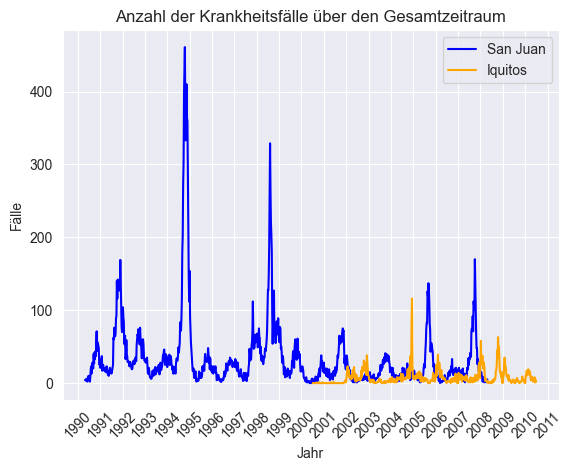

In [514]:
df_sj_train['week_start_date'] = pd.to_datetime(df_sj_train['week_start_date'], format='%Y-%m-%d')
df_iq_train['week_start_date'] = pd.to_datetime(df_iq_train['week_start_date'], format='%Y-%m-%d')

fig, ax = plt.subplots()

ax.plot(df_sj_train['week_start_date'], df_sj_labels['total_cases'], label='San Juan', color='blue')
ax.plot(df_iq_train['week_start_date'], df_iq_labels['total_cases'], label='Iquitos', color='orange')

ax.set_title('Anzahl der Krankheitsfälle über den Gesamtzeitraum')
ax.set_xlabel('Jahr')
ax.set_ylabel('Fälle')
ax.legend()

# Setzen Sie die Locator- und Formatter-Objekte für die x-Achse
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Locator für 1-Jahres-Schritte
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formatter für das Anzeigen des Jahres

plt.xticks(rotation=45)  # Optional: Drehen Sie die Jahreszahlen für eine bessere Lesbarkeit

plt.savefig('pictures/total_cases_im_gesamtzeitraum.png', bbox_inches="tight")
plt.show()

### Fehlende Werte
Hier werden fehlende Werte visualisiert.
Man sieht zwei Daten die, außer die NDVI-Attribute, null Werte besitzen. Sie sind mit dem Datum 1992-01-01 und 1998-01-01 gekennzeichnet.
Es gibt eine große Lücke an Werten der NDVI-Attribute von 1994-09-24 bis 1994-12-24

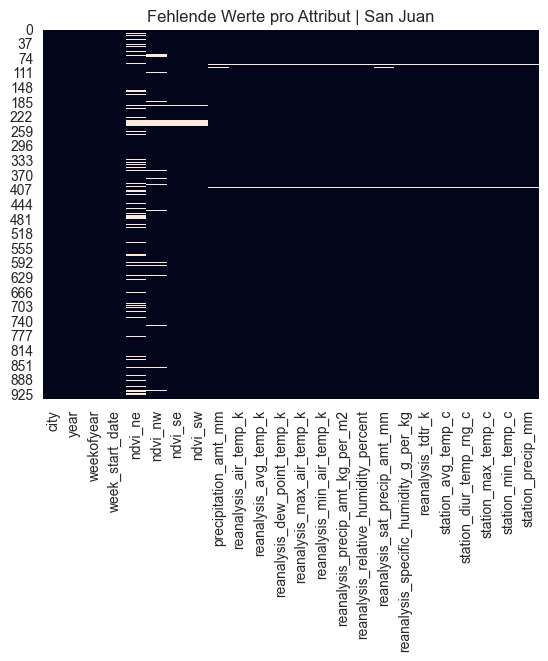

In [515]:
sns.heatmap(df_sj_train.isnull(), cbar=False).set(title='Fehlende Werte pro Attribut | San Juan')
plt.savefig('pictures/null_werte_pro_attribut_sj.png',bbox_inches="tight")
plt.show()

Hier sieht man die Attribute, die am meisten mit null Werten belegt sind. 
Die NDVI-Attribute sind ganz oben, mit 'ndvi_ne' am lückenhaftesten.

In [516]:
def missing_data_percent(df):
    # Verteilung der fehlenden Daten
    null_vals = df.isnull().sum()
    total_vals = len(df)
    null_percent = (null_vals / total_vals) * 100
    df_null_percent = pd.DataFrame({'Attribut': null_vals.index, 'Prozent': null_percent.values})
    barplot = sns.barplot(x='Attribut', y='Prozent', data=df_null_percent)
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.title('Prozentige Verteilung der fehlenden Daten pro Attribut | San Juan')
    plt.savefig('pictures/prozentverteilung_null_werte_sj.png',bbox_inches="tight")
    plt.show()

C:\Users\rener\AppData\Local\Temp\ipykernel_23448\1660113403.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=40, ha="right")


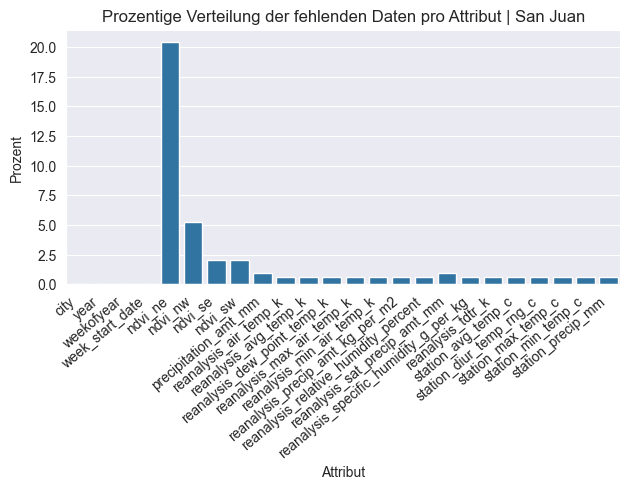

In [517]:
missing_data_percent(df_sj_train)

## Wertebereichverteilung
In welchen Wertebereichen liegen die Werte der Attribute?

In [518]:
def max_min_avg(df):
    # Zeigt Minimum, Maximum und Durchschnitt der Attribute
    result_df = pd.DataFrame({
    'max': df_sj_ignored.max(),
    'min': df_sj_ignored.min(),
    'avg': df_sj_ignored.mean()
    })
    return result_df

In [519]:
max_min_avg(df_sj_ignored)

max         min         avg
ndvi_ne                                  0.493400   -0.406250    0.057925
ndvi_nw                                  0.437100   -0.456100    0.067469
ndvi_se                                  0.393129   -0.015533    0.177655
ndvi_sw                                  0.381420   -0.063457    0.165956
precipitation_amt_mm                   390.600000    0.000000   35.470809
reanalysis_air_temp_k                  302.200000  295.938571  299.163653
reanalysis_avg_temp_k                  302.164286  296.114286  299.276920
reanalysis_dew_point_temp_k            297.795714  289.642857  295.109519
reanalysis_max_air_temp_k              304.300000  297.800000  301.398817
reanalysis_min_air_temp_k              299.900000  292.600000  297.301828
reanalysis_precip_amt_kg_per_m2        570.500000    0.000000   30.465419
reanalysis_relative_humidity_percent    87.575714   66.735714   78.568181
reanalysis_sat_precip_amt_mm           390.600000    0.000000   35.470809
reanalysis_specific_humidity_g_per_kg   19.440000   11.715714   16.552409
reanalysis_tdtr_k                        4.428571    1.357143    2.516267
station_avg_temp_c                      30.071429   22.842857   27.006528
station_diur_temp_rng_c                  9.914286    4.528571    6.757373
station_max_temp_c                      35.600000   26.700000   31.607957
station_min_temp_c                      25.600000   17.800000   22.600645
station_precip_mm                      305.900000    0.000000   26.785484

In [520]:
def attribute_distribution_histogram(df,rows,cols):
    # Erstellt Histogramme der Attribute
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    axs = axs.flatten()
    for i, column in enumerate(df.columns):
        sns.histplot(data=df, x=column, kde=True, color="skyblue", ax=axs[i])
    plt.tight_layout()
    plt.show()

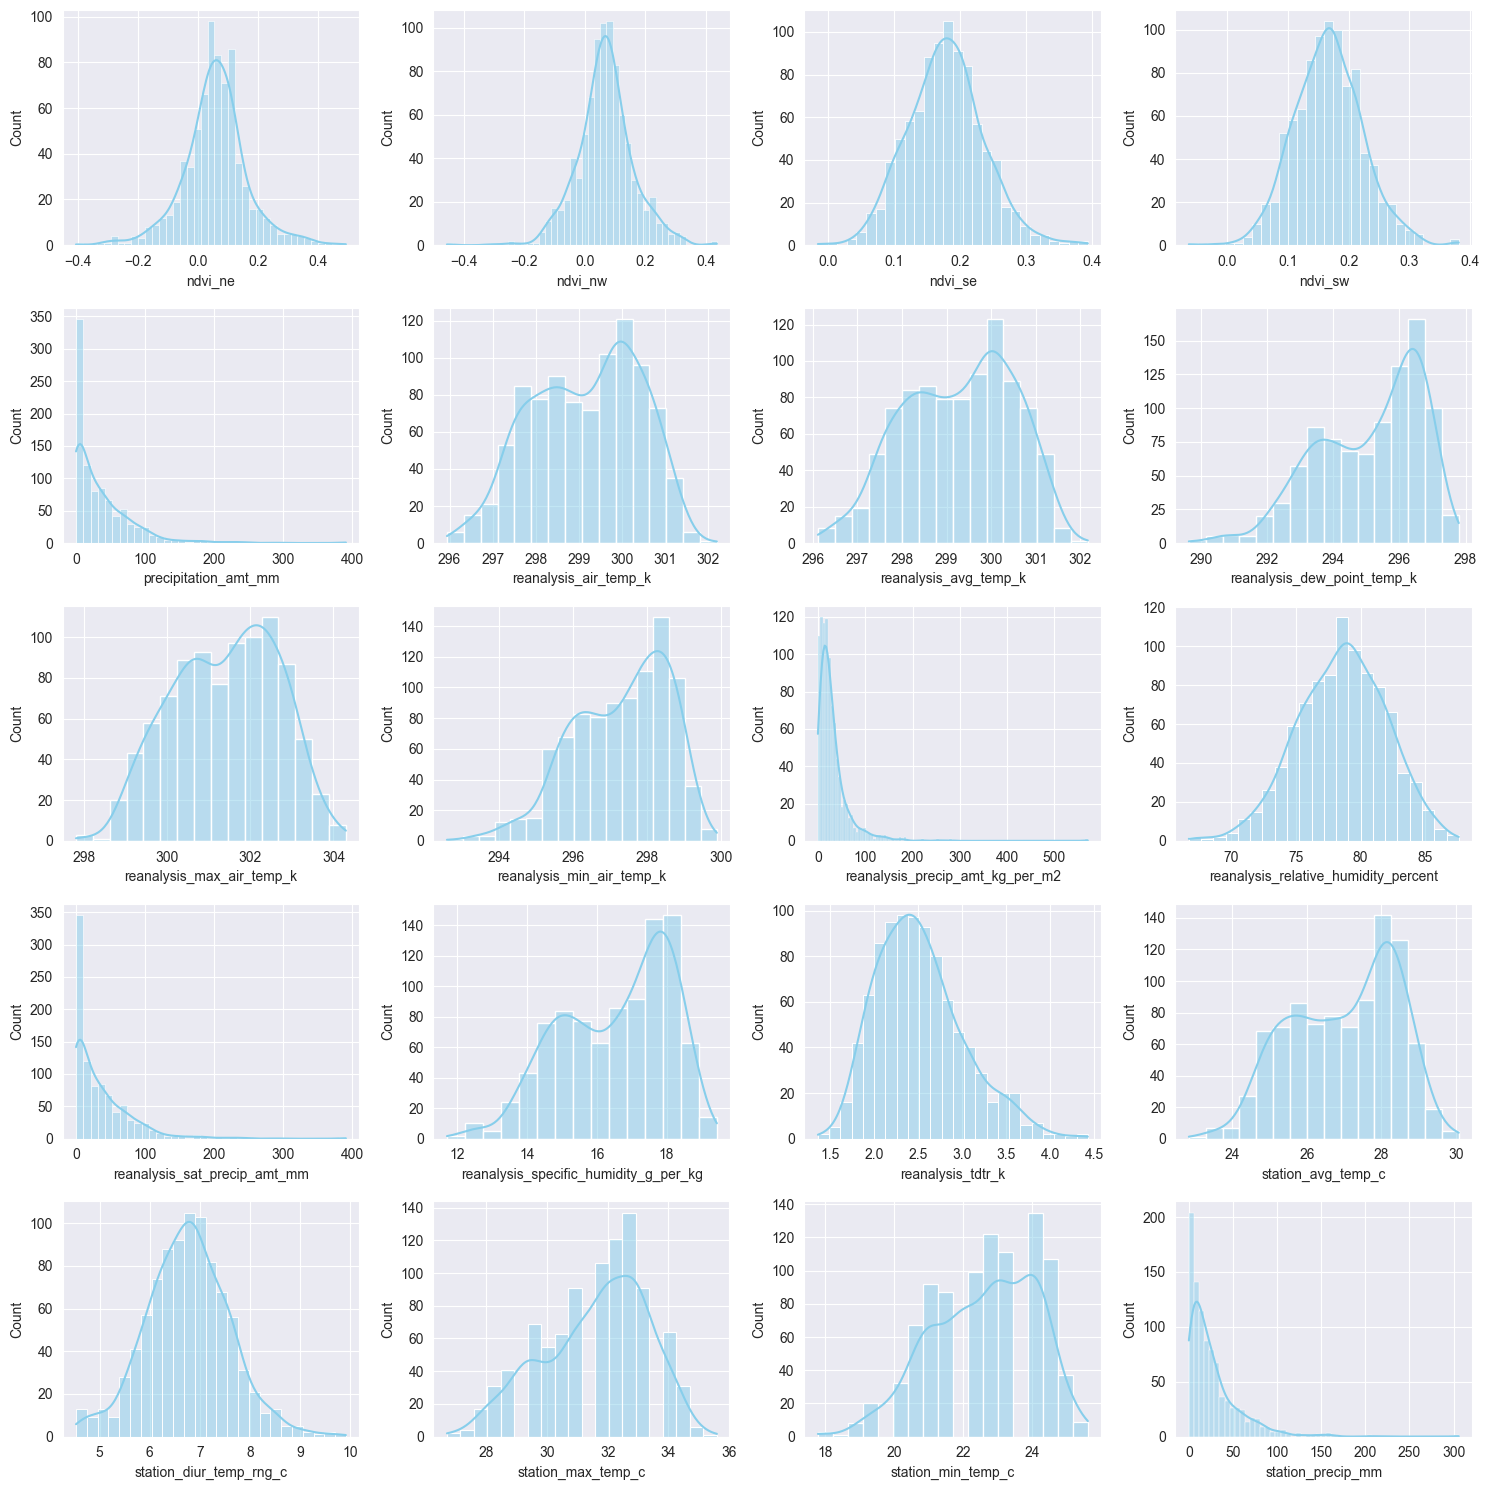

In [521]:
attribute_distribution_histogram(df_sj_ignored,5,4)

### Ausreißer
In sj
wenige Ausreißer bei temperaturbedingten Attributen
mäßige Ausreißer bei Vegetationsdaten
sehr viele Ausreißer bei Niederschlagsdaten

In [522]:
def outlier_boxplot(df):
    # Erstellt Boxplots für jedes Attribut
    num_columns = len(df.columns)
    num_rows = -(-num_columns // 4)
    fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
    axes = axes.flatten()
    for idx, column in enumerate(df.columns):
        sns.boxplot(y=df[column], ax=axes[idx])
        axes[idx].set_title(column)
    for i in range(num_columns, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

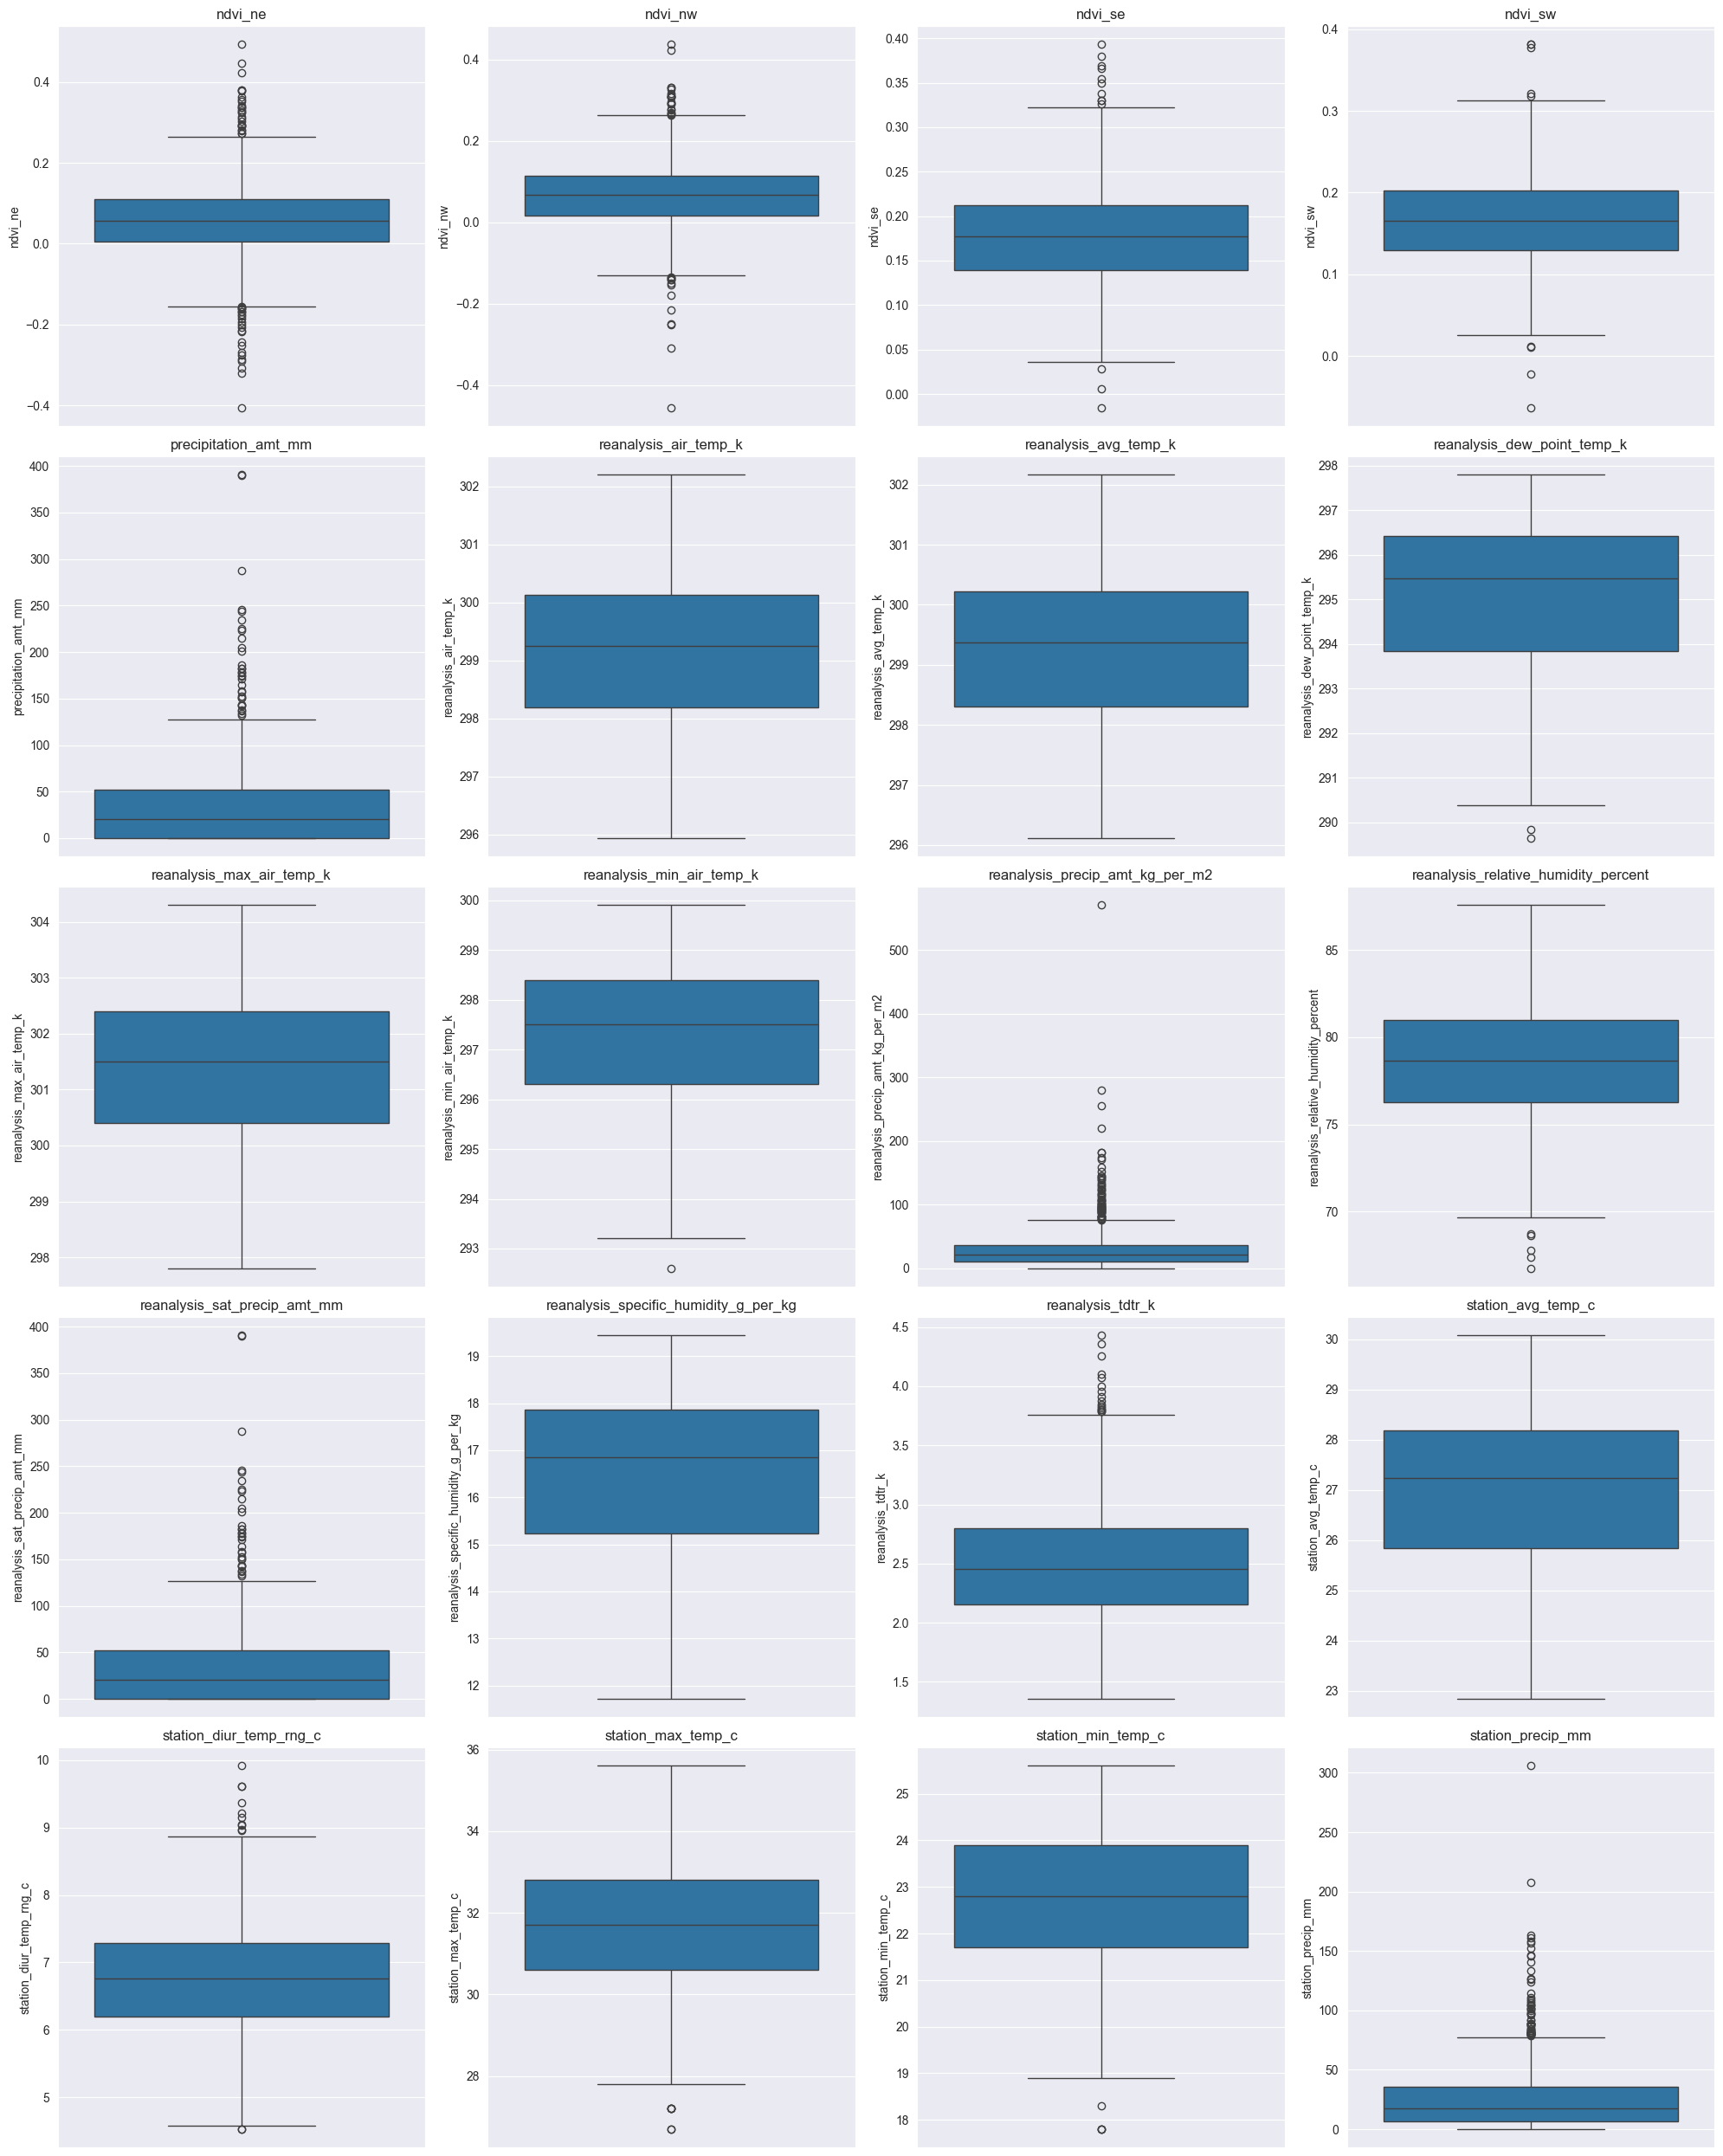

In [523]:
outlier_boxplot(df_sj_ignored)

### Korrelierende Daten

In [524]:
def correlation_matrix(df,df_goal,col_list,annotation):
    df_corr = df[col_list].copy()
    df_corr['total_cases'] = df_goal['total_cases'].copy()
    plt.figure(figsize=[10,10])
    sns.heatmap(df_corr.corr(numeric_only=True),square=True, vmin=-1, vmax=1, 
                center=0, cmap='RdBu_r', annot=annotation)
    plt.show()

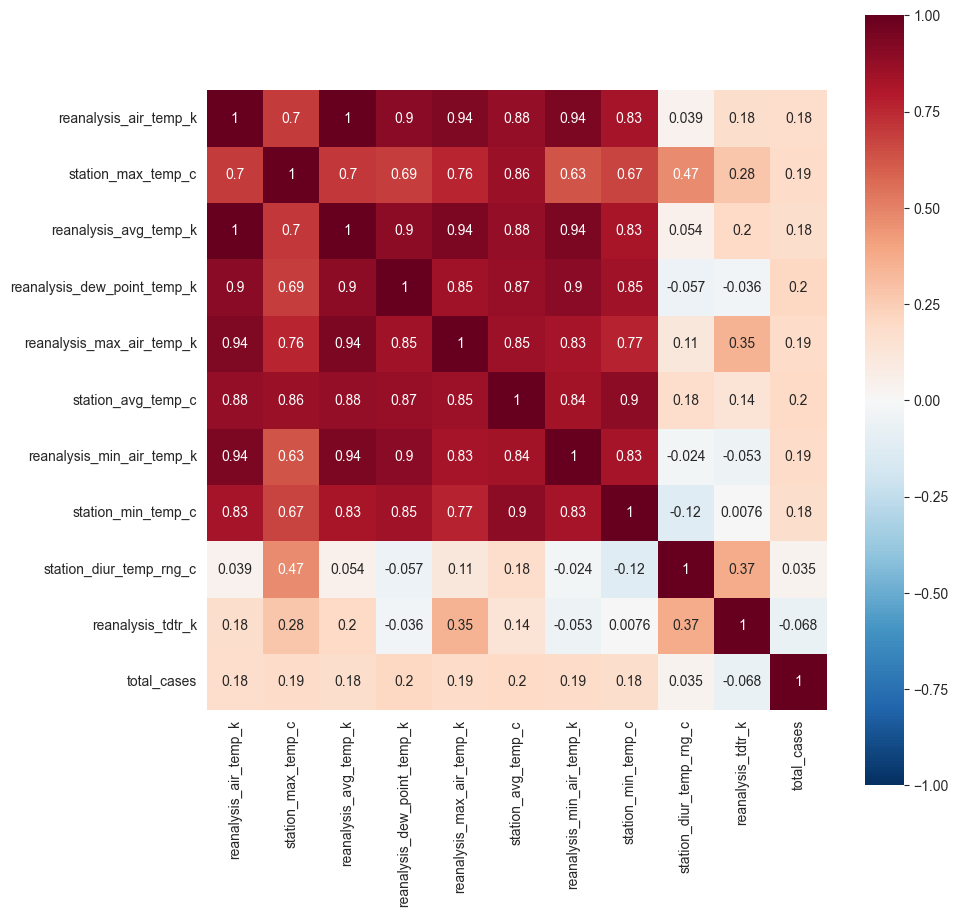

In [525]:
correlation_matrix(df_sj_train,df_sj_labels, ['reanalysis_air_temp_k',
                           'station_max_temp_c',
                           'reanalysis_avg_temp_k',
                           'reanalysis_dew_point_temp_k',
                           'reanalysis_max_air_temp_k',
                           'station_avg_temp_c',
                           'reanalysis_min_air_temp_k',
                           'station_min_temp_c',
                           'station_diur_temp_rng_c',
                           'reanalysis_tdtr_k',
                           ],True)

Die Korrelationsmatrix zeigt, dass die Attribute der Temperaturspannen ('station_diur_temp_rng_c','reanalysis_tdtr_k') nicht mit den Krankheitsfällen korrelieren und werden deswegen für die Weiterverarbeitung nicht benötigt
Weiterhin kann man sehen, dass alle restlichen temperaturbezogenen Attribute stark miteinander korrelieren. Demnach können sie normalisiert werden und mit dem gemeinsamen Durchschnitt zu einer Variable zusammengefasst werden. Eine Ausnahme ist hierbei 'station_max_temp_c', weil es nicht so stark mit den anderen Temperaturvariablen korreliert, aber dennoch mit der Zielvariable korreliert. Diese Variable kann ohne weiteres verwendet werden

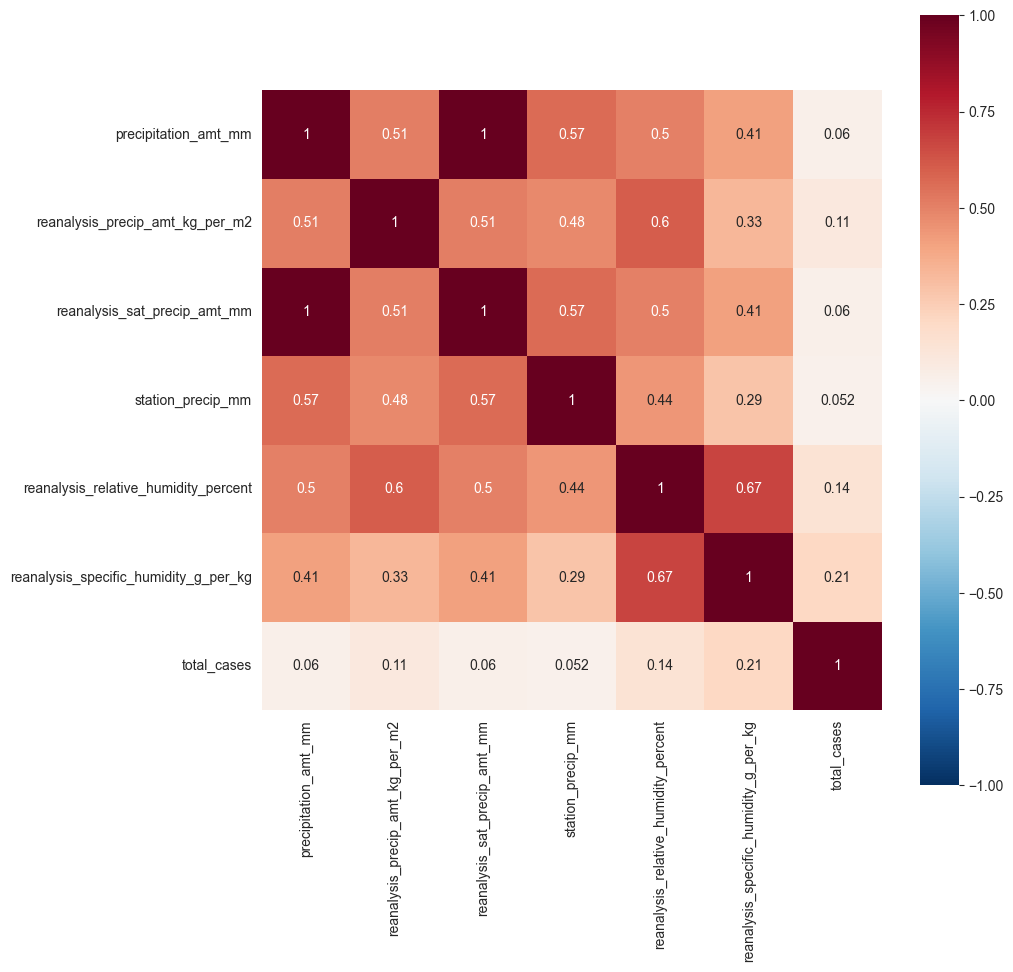

In [526]:
# Niederschlagsdaten
correlation_matrix(df_sj_train,df_sj_labels,['precipitation_amt_mm',
                             'reanalysis_precip_amt_kg_per_m2',
                             'reanalysis_sat_precip_amt_mm',
                             'station_precip_mm',
                             'reanalysis_relative_humidity_percent',
                             'reanalysis_specific_humidity_g_per_kg'],True)

Zu erkennen ist, dass 'precipitation_amt_mm' und 'reanalysis_sat_precip_amt_mm' gleich sind. Dies wird durch einen Blick durch die Daten bestätigt.
Jedoch ist ihre Korrelation zu 'total_cases' sehr niedrig, was bedeutet, dass sie nicht geeignet sind.

In [527]:
df_sj_train[['precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm']].head()

precipitation_amt_mm  reanalysis_sat_precip_amt_mm
0                 12.42                         12.42
1                 22.82                         22.82
2                 34.54                         34.54
3                 15.36                         15.36
4                  7.52                          7.52

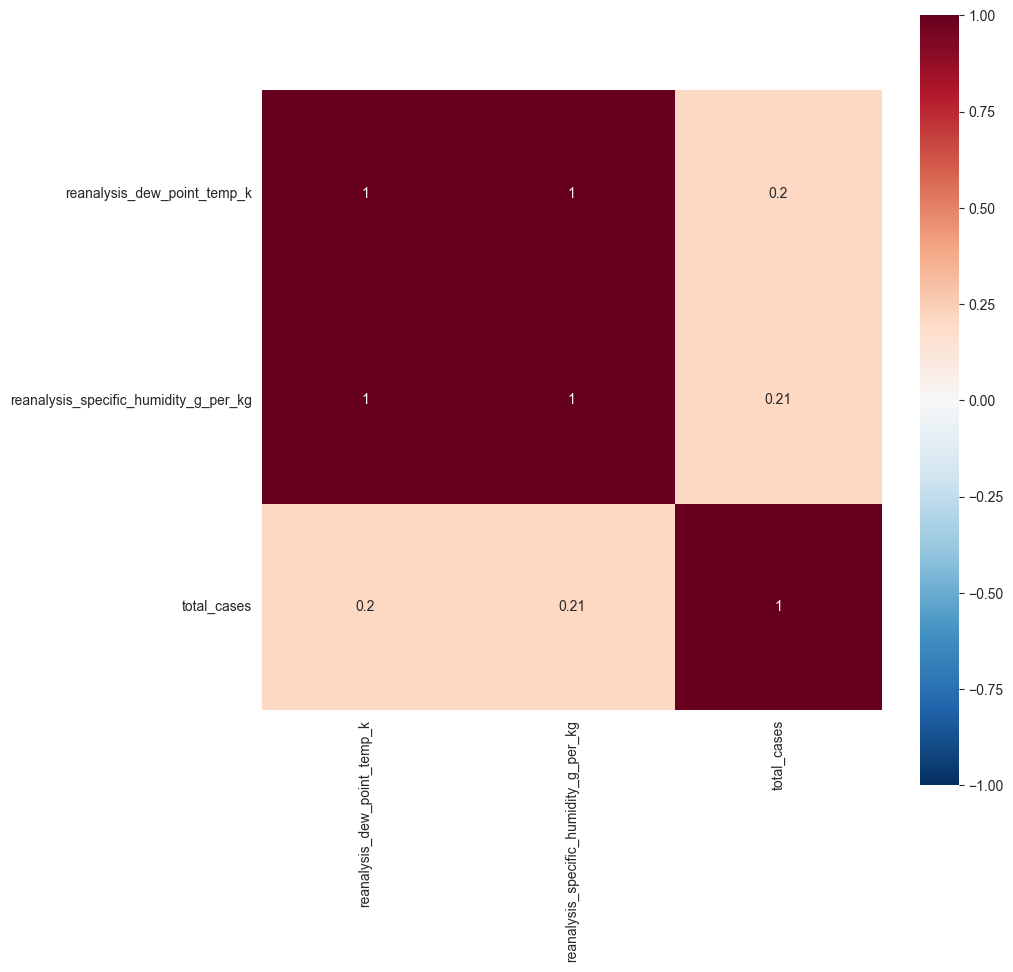

In [528]:

correlation_matrix(df_sj_train,df_sj_labels,['reanalysis_dew_point_temp_k',
                             'reanalysis_specific_humidity_g_per_kg'],True)

Die beiden Attribute korrelieren stark und haben auch ungefähr den gleichen Einfluss auf die Zielvariable. Sie können standardisiert und zusammengefasst werden

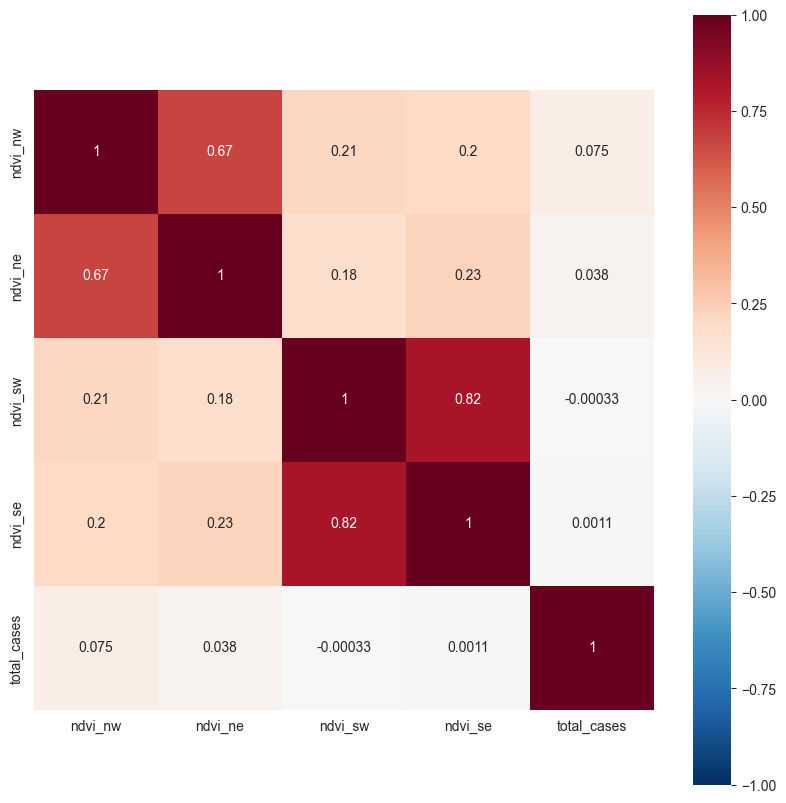

In [529]:
# Vegetationsdaten und Zielvariable
correlation_matrix(df_sj_train,df_sj_labels,['ndvi_nw','ndvi_ne','ndvi_sw','ndvi_se',],True)

Die Korrelationsmatrix zeigt, dass die Vegetationsdaten sehr wenig mit den Krankheitsfällen korrelieren.

C:\Users\rener\AppData\Local\Temp\ipykernel_23448\3891561992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_train['total_cases']=df_sj_labels['total_cases']
C:\Users\rener\AppData\Local\Temp\ipykernel_23448\3891561992.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sj_correlations = df_sj_train.corr()


<AxesSubplot: >

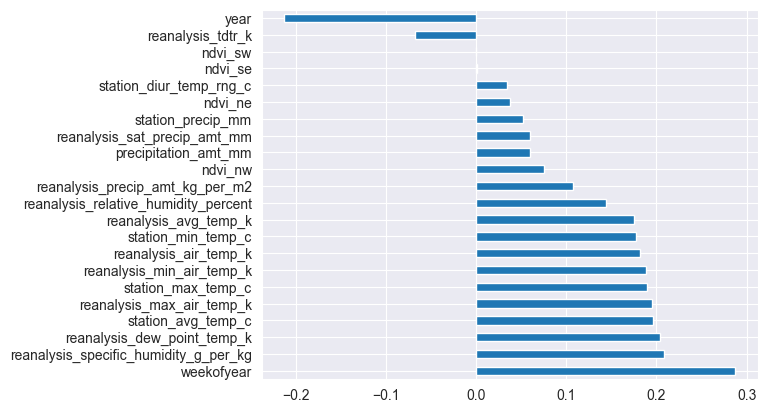

In [530]:
df_sj_train['total_cases']=df_sj_labels['total_cases']
sj_correlations = df_sj_train.corr()
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

# Datenpräparation
Welche Daten sollen für das weitere Vorgehen ausgewählt werden?
Welche Daten und Attribute müssen bereinigt werden?
Wie wird mit Ausreißern umgegangen?
Müssen Daten transformiert werden?
Müssen Daten formatiert werden? (Manche wurden schon formatiert: 'week_start_date' wurde von String in Datetime formatiert) 

### Auswahl der Attribute
Ein DataFrame mit allen ausgewählten Variablen zur Erstellung des Models wird erstellt.

In [531]:
df_sj_model_features = df_sj_train[['station_max_temp_c',
                                    'reanalysis_relative_humidity_percent',
                                    'reanalysis_precip_amt_kg_per_m2']].copy() 

### Normalisierung
Die Temperaturdaten werden normalisiert.

In [532]:
def normalize_cols(df_in,df_out,cols,name):
    scaler = MinMaxScaler()
    df_temp = df_in[cols].copy()
    df_out[name] = pd.DataFrame(scaler.fit_transform(df_temp), columns=df_temp.columns).mean(axis=1).copy()

In [533]:
temp_cols = ['reanalysis_air_temp_k',
                           'reanalysis_avg_temp_k',
                           'reanalysis_max_air_temp_k',
                           'station_avg_temp_c',
                           'reanalysis_min_air_temp_k',
                           'station_min_temp_c',
                           'reanalysis_dew_point_temp_k']
normalize_cols(df_sj_train,df_sj_model_features,temp_cols,'temp_avg')

In [534]:
humid_cols = ['reanalysis_specific_humidity_g_per_kg']
normalize_cols(df_sj_train,df_sj_model_features,humid_cols,'norm_humid_amount')

In [535]:
scaler = MinMaxScaler()
norm_atts = ['station_max_temp_c', 'reanalysis_relative_humidity_percent', 'reanalysis_precip_amt_kg_per_m2']
df_sj_model_features[norm_atts] = scaler.fit_transform(df_sj_model_features[norm_atts])

### Behandlung von fehlenden Daten
Bei näherer Betrachtung gibt es Jahre mit Woche 53 (z.B. 1993), die immer aus null-Werten bestehen.
Auch ist die Woche 1 des Vorjahres der vorher genannten Jahren null.
Nach Abgleich mit den originellen Daten auf der Website wurde herausgefunden, dass sich die Daten verschoben haben.
Andere Mitbewerber des Wettbewerbs haben verschiedene Lösungsansätze verwendet, unter anderem die Löschung der Daten oder die Imputation anhand der Attribute.
Hier wird der Lösungsansatz des Github Users "conditg" verwendet, welche in der Datei "https://github.com/conditg/deng-ai/blob/master/SanJuan.ipynb" gefunden werden kann.
Die Wochen wurden alle um 1 inkrementiert und die resultierenden Wochen größer als 52 wurden ab Woche 1 begonnen

In [536]:
#Increment all week values by one for all problem years
df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.year==1993,df_sj_train.weekofyear+1, df_sj_train.weekofyear)
for year in [1994,1995,1999,2000,2005,2006]:
    df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.year==year,df_sj_train.weekofyear_fixed+1, df_sj_train.weekofyear_fixed)

#Reduce any week values over 52 down to 1    
df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.weekofyear_fixed>52,1, df_sj_train.weekofyear_fixed)



df_sj_labels.loc[:,'weekofyear_fixed'] = np.where(df_sj_labels.year==2010,
                                              df_sj_labels.weekofyear+1, df_sj_labels.weekofyear) 
for year in [2011,2012]:
    df_sj_labels.loc[:,'weekofyear_fixed'] = np.where(df_sj_labels.year==year,
                                                  df_sj_labels.weekofyear_fixed+1, df_sj_labels.weekofyear_fixed)
df_sj_labels.loc[:,'weekofyear'] = np.where(df_sj_labels.weekofyear_fixed>52,
                                        1, df_sj_labels.weekofyear_fixed)

C:\Users\rener\AppData\Local\Temp\ipykernel_23448\2082988004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.year==1993,df_sj_train.weekofyear+1, df_sj_train.weekofyear)
C:\Users\rener\AppData\Local\Temp\ipykernel_23448\2082988004.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.year==year,df_sj_train.weekofyear_fixed+1, df_sj_train.weekofyear_fixed)
C:\Users\rener\AppData\Local\T

In [537]:
df_sj_model_features['weekofyear_fixed'] = df_sj_train['weekofyear_fixed'].copy()
df_sj_model_features['total_cases'] = df_sj_labels['total_cases'].copy()

Aus den Methoden zum Auffüllen von Zeitreihendaten wurde Interpolation ausgewählt


In [538]:
df_sj_model_features = df_sj_model_features.interpolate(method='linear', limit_direction='both', limit=26)

In [539]:
df_sj_model_features.drop(['weekofyear_fixed'],axis=1,inplace=True)

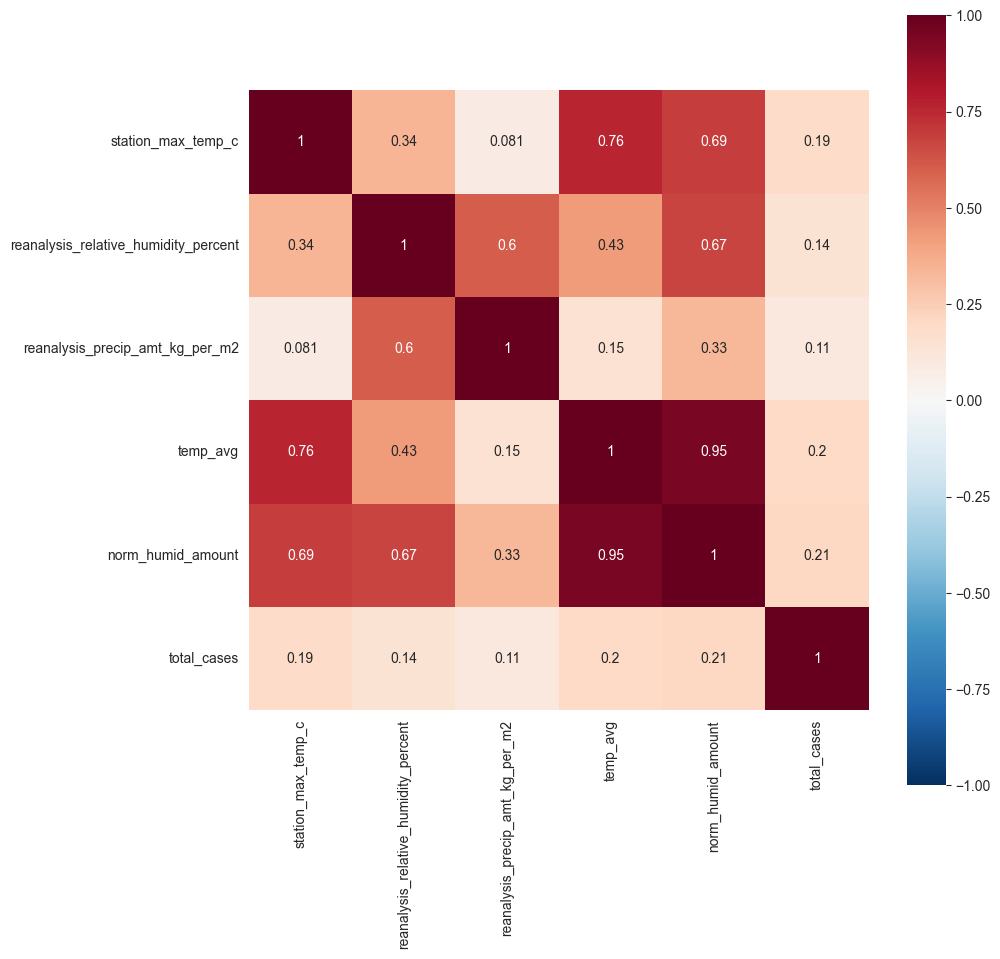

In [540]:
temp = df_sj_model_features.columns
df_corr = df_sj_model_features[temp].copy()
plt.figure(figsize=[10,10])
sns.heatmap(df_corr.corr(numeric_only=True),square=True, vmin=-1, vmax=1, 
                center=0, cmap='RdBu_r', annot=True)
plt.show()

# Aufbau des Models
Der Datensatz wird in Trainingsdaten und Testdaten aufgeteilt. Es wird mit einem chronologischen 70%:30%-Split aufgeteilt.

In [541]:
x = df_sj_model_features.drop(['total_cases'], axis=1)
y = df_sj_model_features['total_cases']
sj_x_train, sj_x_test, sj_y_train, sj_y_test = train_test_split(x, y, test_size=0.3, random_state=42,shuffle=False)

### Vorhersage durch lineare Regression

In [542]:
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score

linear_reg_sj_simple = LinearRegression()
linear_reg_sj_simple.fit(sj_x_train,sj_y_train)
y_pred_linear_reg = linear_reg_sj_simple.predict(sj_x_test)
print(cross_val_score(linear_reg_sj_simple,sj_x_train,sj_y_train,scoring='neg_mean_absolute_error', cv=4))
print(mean_absolute_error(sj_y_test,y_pred_linear_reg,multioutput='uniform_average'))

[-29.5563171  -44.55898472 -30.55502179 -35.55483812]
26.188879027394403


In [543]:
linear_reg_sj_simple.score(sj_x_test,sj_y_test)

-0.2830698349175509

In [544]:
def examine(y_pred, y_test):
    c = pd.DataFrame({
        'y' : y_test,
        'p' : y_pred
     })
    c = c.sort_index()
    plt.figure(figsize=[15,4])
    plt.plot(c.y, color='green')
    plt.plot(c.p, color='red')
    plt.show()

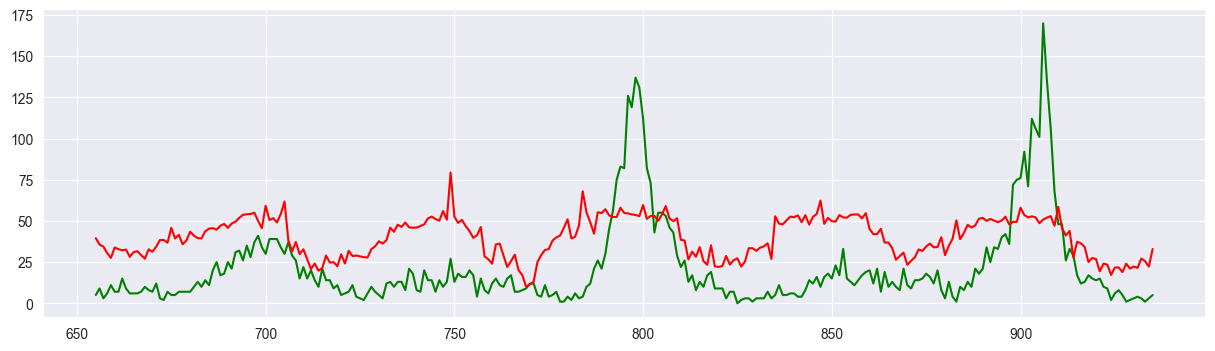

In [545]:
examine(y_pred_linear_reg, sj_y_test)

# Feature Engineering
Können die Scores verbessert werden durch Feature Engineering?

### Saisonaler Aspekt der Zeitreihe
Anhand der Zeitreihendekomposition lassen sich Muster, wie Trend, Saison, etc. erkennen.

In [546]:
def time_series_decomp(df,y,ticks):
    result = seasonal_decompose(df[y],period=52)
    seasonal = result.seasonal
    trend = result.trend
    resid = result.resid
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(df[y], label='Original')
    plt.legend(loc='upper left')
    plt.xticks(ticks)
    
    plt.subplot(4, 1, 2)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.xticks(ticks)
    
    plt.subplot(4, 1, 3)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.xticks(ticks)
    
    plt.subplot(4, 1, 4)
    plt.plot(resid, label='Residual')
    plt.legend(loc='upper left')
    plt.xticks(ticks)
    
    plt.title(y)
    plt.tight_layout()
    plt.show()

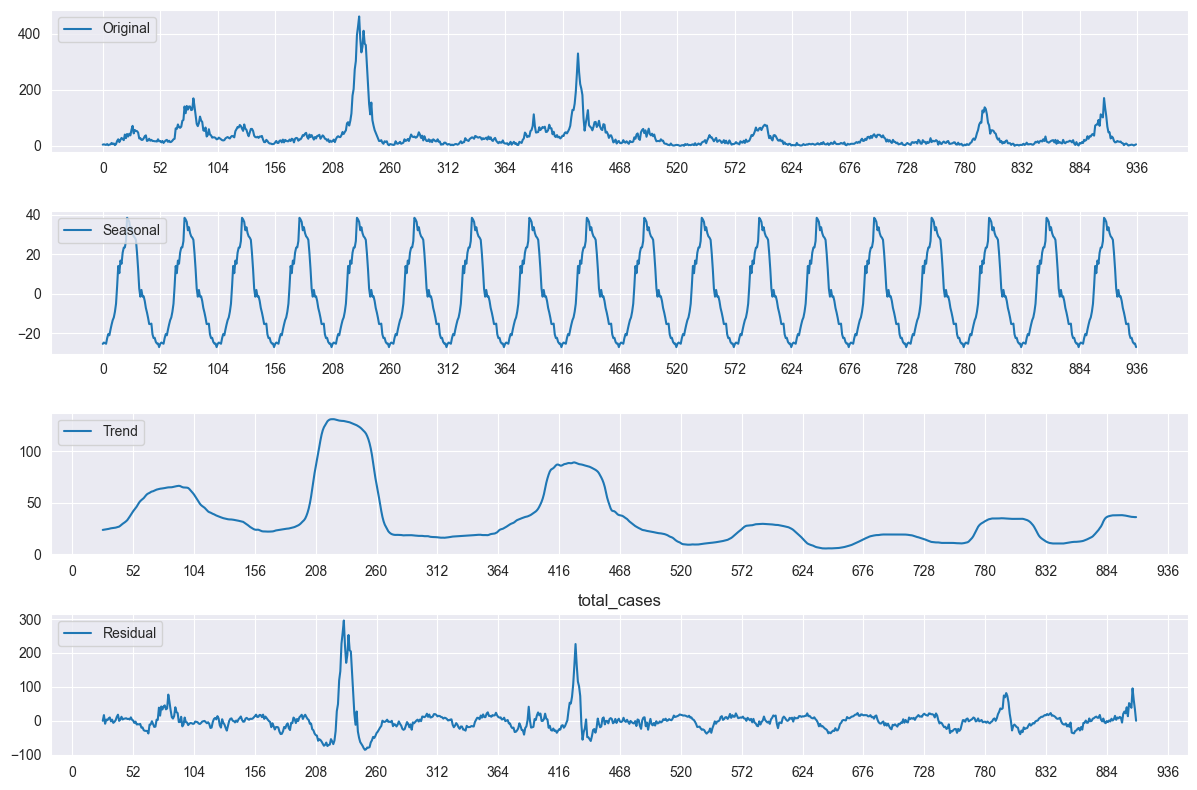

In [547]:
ticks = [0,52,104,156,208,260,312,364,416,468,520,572,624,676,728,780,832,884,936]
time_series_decomp(df_sj_model_features,'total_cases',ticks)

Die Saison-Komponente zeigt, dass sich die Höhepunkte regelmäßig wiederholen. Um näheren Einblick zu bekommen können die Wochen jedes Jahres abgebildet werden

In [548]:
df_sj_lineplot = df_sj_train[['weekofyear_fixed','year']].copy()
df_sj_lineplot['total_cases'] = df_sj_labels['total_cases'].copy()

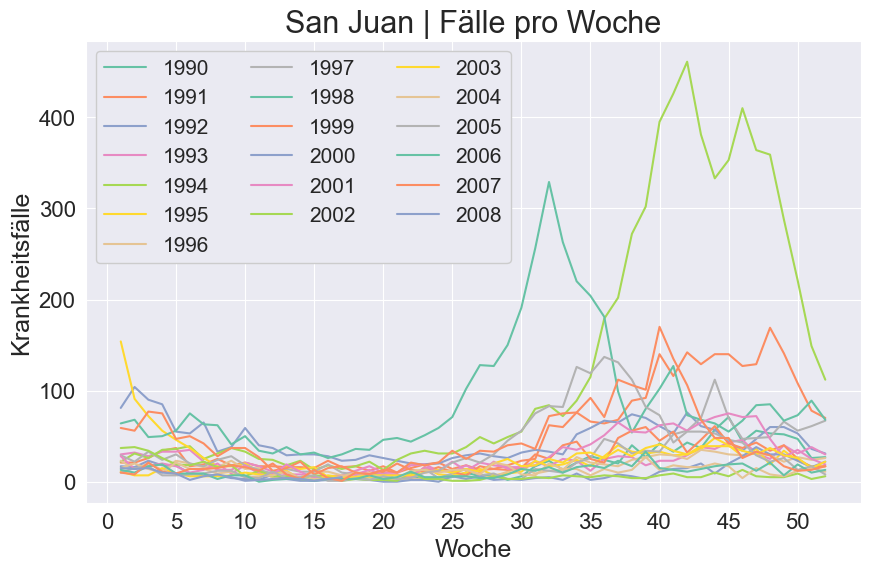

In [549]:
plt.figure(figsize=[10,6])
sns.lineplot(x='weekofyear_fixed',y='total_cases', hue='year',
                data=df_sj_lineplot, palette='Set2',legend='full')
plt.legend(loc=2, framealpha=1, ncol=3, prop={'size': 15})    
plt.ylabel('Krankheitsfälle',size=18)
plt.xlabel('Woche',size=18)
plt.xticks([0,5,10,15,20,25,30,35,40,45,50], size=16)
plt.yticks(size=16)
plt.title('San Juan | Fälle pro Woche', size=22)
plt.show()

Man kann drei Phasen im Jahr sehen: 
1.  Woche 1-11: Abnehmende Fallanzahl
2.  Woche 12-22: Gleichbleibende Fallanzahl mit Minima
3.  Woche 23-52: stark steigende Fallanzahl mit Maxima
Diese können mithilfe von Feature Engineering mit eigenen Attributen im DataFrame repräsentiert werden. 

In [550]:
for index, row in df_sj_train.iterrows():
    phase = 0
    if 0 <= row['weekofyear_fixed'] <= 11:
        phase = 1
    elif 12 <= row['weekofyear_fixed'] <= 22:
        phase = 2
    elif 23 <= row['weekofyear_fixed'] <= 52:
        phase = 3

    df_sj_model_features.loc[index, 'phase1'] = 1 if phase == 1 else 0
    df_sj_model_features.loc[index, 'phase2'] = 1 if phase == 2 else 0
    df_sj_model_features.loc[index, 'phase3'] = 1 if phase == 3 else 0

Nun wird überprüft, ob die Phasen auch mit der Zielvariablen korrelieren

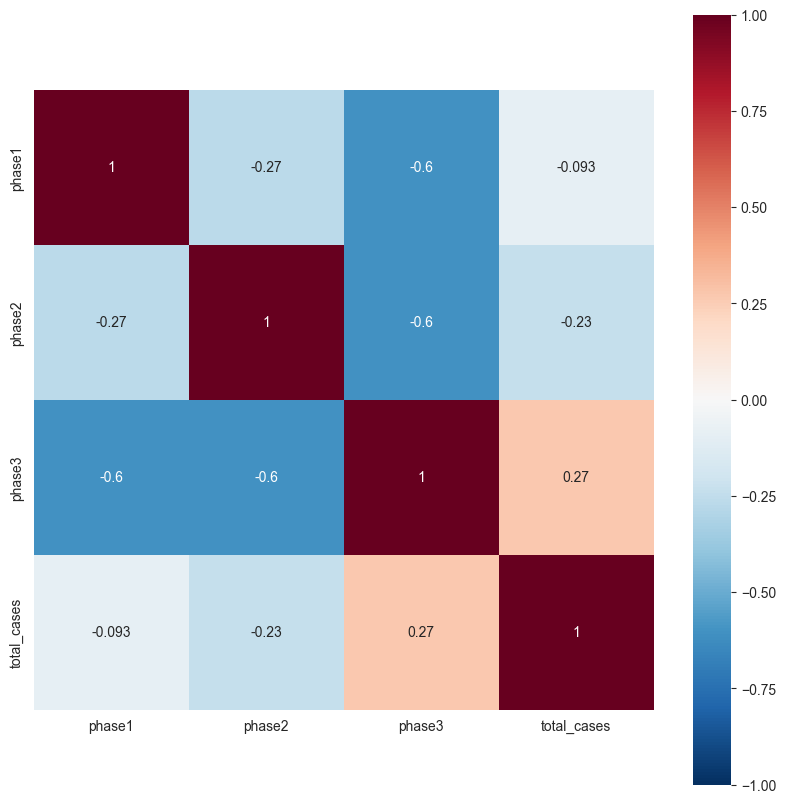

In [551]:
correlation_matrix(df_sj_model_features,df_sj_model_features,['phase1','phase2','phase3'],True)

Phase 3 korreliert mit der Zielvariable. Phase 2 korreliert negativ mit der Zielvariable, also gibt es einen negativen linearen Verlauf, der auch miteinbezogen werden kann. Nur Phase 1 korreliert fast gar nicht und wird ausgeschlossen.

In [552]:
df_sj_model_features.drop(columns=['phase1'],inplace=True)

Nun wird wieder die lineare Regression durchgeführt

In [553]:
x = df_sj_model_features.drop(['total_cases'], axis=1)
y = df_sj_model_features['total_cases']
sj_x_train, sj_x_test, sj_y_train, sj_y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [554]:
linear_reg_sj_phases = LinearRegression()
linear_reg_sj_phases.fit(sj_x_train,sj_y_train)
y_pred_linear_reg = linear_reg_sj_phases.predict(sj_x_test)
print(cross_val_score(linear_reg_sj_phases,sj_x_train,sj_y_train,scoring='neg_mean_absolute_error', cv=4))
print(mean_absolute_error(sj_y_test,y_pred_linear_reg,multioutput='uniform_average'))

[-25.63400191 -30.75348918 -26.36999005 -21.05415642]
28.080326248823706


In [555]:
linear_reg_sj_phases.score(sj_x_test,sj_y_test)

0.08710867168232006

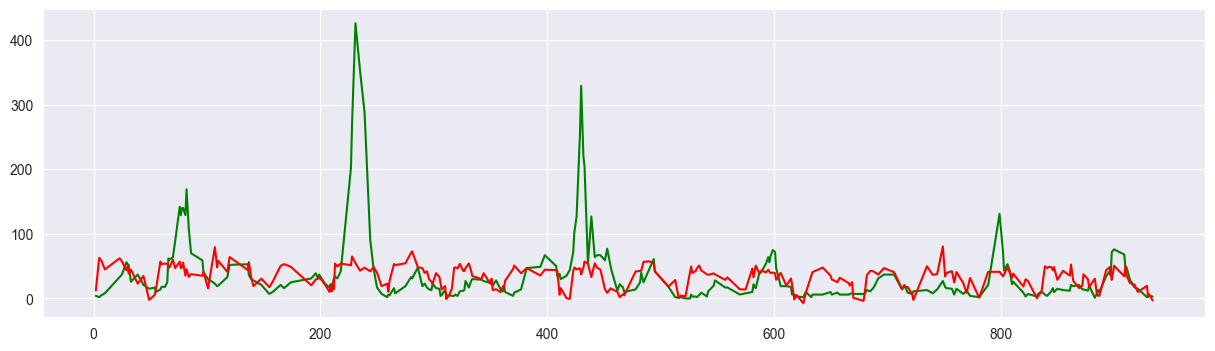

In [556]:
examine(y_pred_linear_reg, sj_y_test)

### Random Forest Regression

In [557]:
from sklearn.ensemble import RandomForestRegressor

In [558]:
x = df_sj_model_features.drop(['total_cases'], axis=1)
y = df_sj_model_features['total_cases']
sj_x_train_rndm, sj_x_test_rndm, sj_y_train_rndm, sj_y_test_rndm = train_test_split(x, y, test_size=0.3, random_state=42)

[-23.14682927 -30.4802439  -27.20009146 -23.31027607]
29.30437722419929
0.03522710867746082


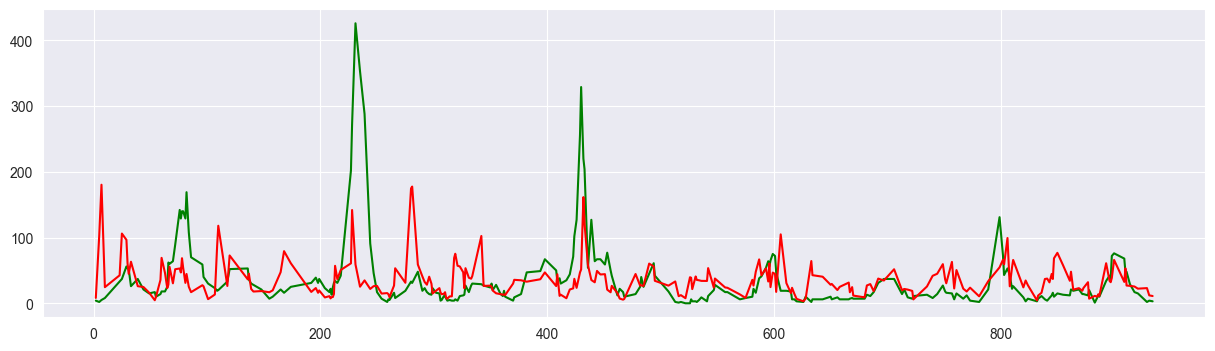

In [559]:
rndm_forest_regr_sj = RandomForestRegressor(criterion="absolute_error", random_state=40)
rndm_forest_regr_sj.fit(sj_x_train_rndm,sj_y_train_rndm)
y_pred_rndm = rndm_forest_regr_sj.predict(sj_x_test_rndm)
print(cross_val_score(rndm_forest_regr_sj, sj_x_train_rndm, sj_y_train_rndm, scoring='neg_mean_absolute_error', cv=4))
print(mean_absolute_error(sj_y_test_rndm, y_pred_rndm, multioutput='uniform_average'))
print(rndm_forest_regr_sj.score(sj_x_test_rndm, sj_y_test_rndm))
examine(y_pred_rndm, sj_y_test_rndm)

## Feature Importance
Die Feature Importance wurde schon durch Verwendung des Korrelationsindexes durchgeführt. Da die ausgewählten Variablen den Datensatz nicht gut beschreiben wird nun eine Feature Importance über alle Variablen mithilfe von Random Forest durchgeführt. Das Ziel ist es, die für die Vorhersage wichtigen Features zu ermitteln.

In [560]:
df_all_features = df_sj_train.copy()
df_all_features.drop(columns=["weekofyear_fixed", "total_cases", "year", "city", "week_start_date"],
                     inplace=True)
df_all_features = df_all_features.interpolate(method='linear', limit_direction='both', limit=26)
df_all_features['phase2'] = df_sj_model_features['phase2'].copy()
df_all_features['phase3'] = df_sj_model_features['phase3'].copy()
df_all_features['phase1'] = 0
df_all_features.loc[(df_all_features['phase2'] == 0) & (df_all_features['phase3'] == 0), 'phase1'] = 1
df_all_features['temp_avg'] = df_sj_model_features['temp_avg']

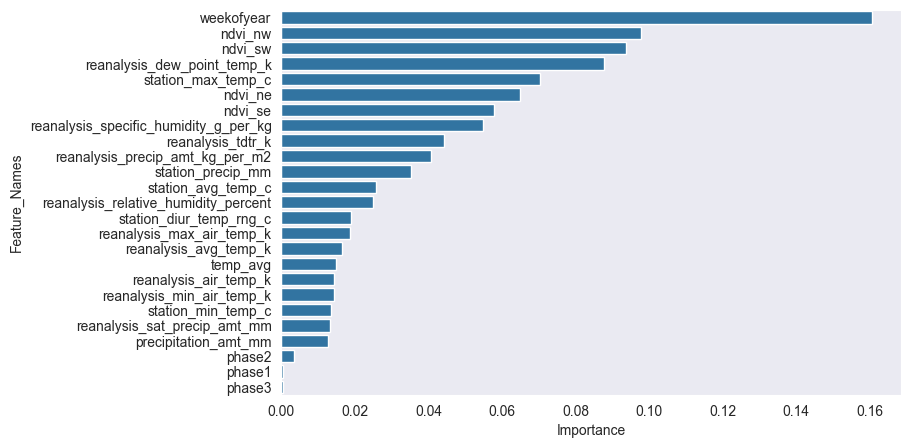

In [561]:
X = df_all_features
y = df_sj_labels['total_cases']
names = df_all_features.columns.values.tolist()

rf_classifier = RandomForestRegressor()
rf_classifier.fit(X, y)
importance = {
    'Feature_Names': names,
    'Importance': rf_classifier.feature_importances_
}
feature_importance = pd.DataFrame(importance)
plt.figure(figsize=(8, 5))
plt.grid()
sns.barplot(x="Wichtigkeit", y="Variable", data=feature_importance.sort_values(by="Importance", ascending=False))
selected_features = feature_importance[feature_importance['Importance'] >= 0.045]
selected_feature_names = selected_features['Feature_Names'].tolist()

[-19.75490854 -28.99064024 -20.61564024 -17.14079755]
23.1894128113879
0.14326325715572819


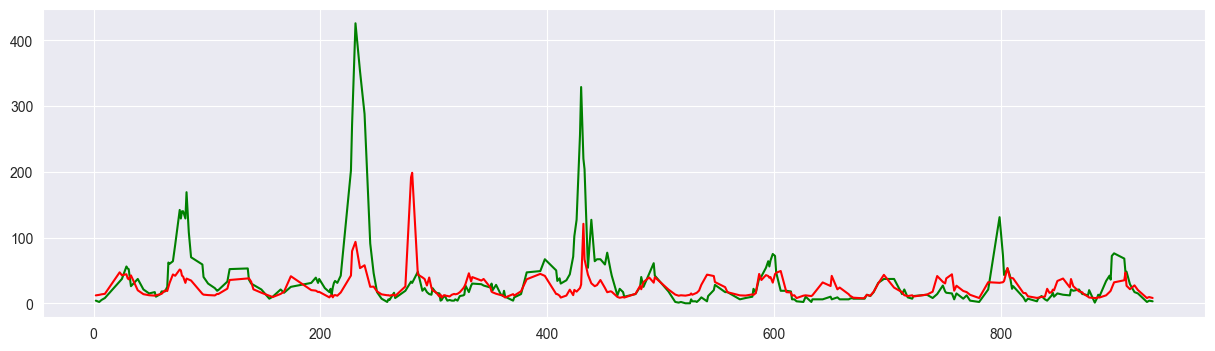

In [562]:
x = df_all_features[selected_feature_names]
y = df_sj_model_features['total_cases']
sj_x_train_rndm, sj_x_test_rndm, sj_y_train_rndm, sj_y_test_rndm = train_test_split(x, y, test_size=0.3,
                                                                                    random_state=42)
rndm_forest_regr_sj = RandomForestRegressor(criterion="absolute_error",max_depth=4)
rndm_forest_regr_sj.fit(sj_x_train_rndm, sj_y_train_rndm)
y_pred_rndm = rndm_forest_regr_sj.predict(sj_x_test_rndm)
print(cross_val_score(rndm_forest_regr_sj, sj_x_train_rndm, sj_y_train_rndm, scoring='neg_mean_absolute_error', cv=4))
print(mean_absolute_error(sj_y_test_rndm, y_pred_rndm, multioutput='uniform_average'))
print(rndm_forest_regr_sj.score(sj_x_test_rndm, sj_y_test_rndm))
examine(y_pred_rndm, sj_y_test_rndm)

# Iquitos Datensatz 
### Fehlende Daten

C:\Users\rener\AppData\Local\Temp\ipykernel_23448\1660113403.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=40, ha="right")


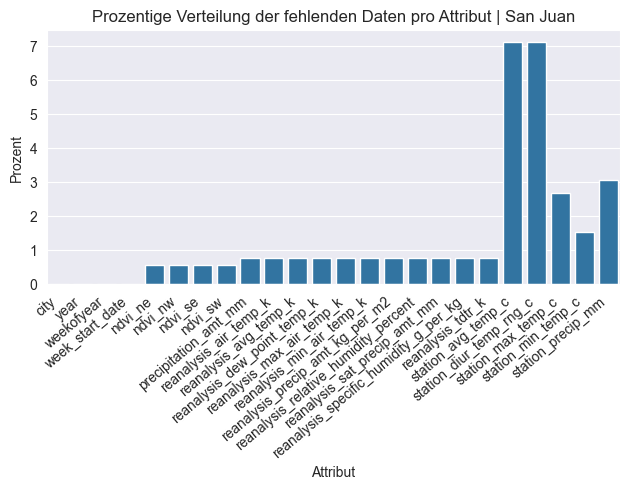

In [563]:
missing_data_percent(df_iq_train)

### Werteverteilung

In [564]:
max_min_avg(df_iq_train)

max         min         avg
ndvi_ne                                  0.493400   -0.406250    0.057925
ndvi_nw                                  0.437100   -0.456100    0.067469
ndvi_se                                  0.393129   -0.015533    0.177655
ndvi_sw                                  0.381420   -0.063457    0.165956
precipitation_amt_mm                   390.600000    0.000000   35.470809
reanalysis_air_temp_k                  302.200000  295.938571  299.163653
reanalysis_avg_temp_k                  302.164286  296.114286  299.276920
reanalysis_dew_point_temp_k            297.795714  289.642857  295.109519
reanalysis_max_air_temp_k              304.300000  297.800000  301.398817
reanalysis_min_air_temp_k              299.900000  292.600000  297.301828
reanalysis_precip_amt_kg_per_m2        570.500000    0.000000   30.465419
reanalysis_relative_humidity_percent    87.575714   66.735714   78.568181
reanalysis_sat_precip_amt_mm           390.600000    0.000000   35.470809
reanalysis_specific_humidity_g_per_kg   19.440000   11.715714   16.552409
reanalysis_tdtr_k                        4.428571    1.357143    2.516267
station_avg_temp_c                      30.071429   22.842857   27.006528
station_diur_temp_rng_c                  9.914286    4.528571    6.757373
station_max_temp_c                      35.600000   26.700000   31.607957
station_min_temp_c                      25.600000   17.800000   22.600645
station_precip_mm                      305.900000    0.000000   26.785484

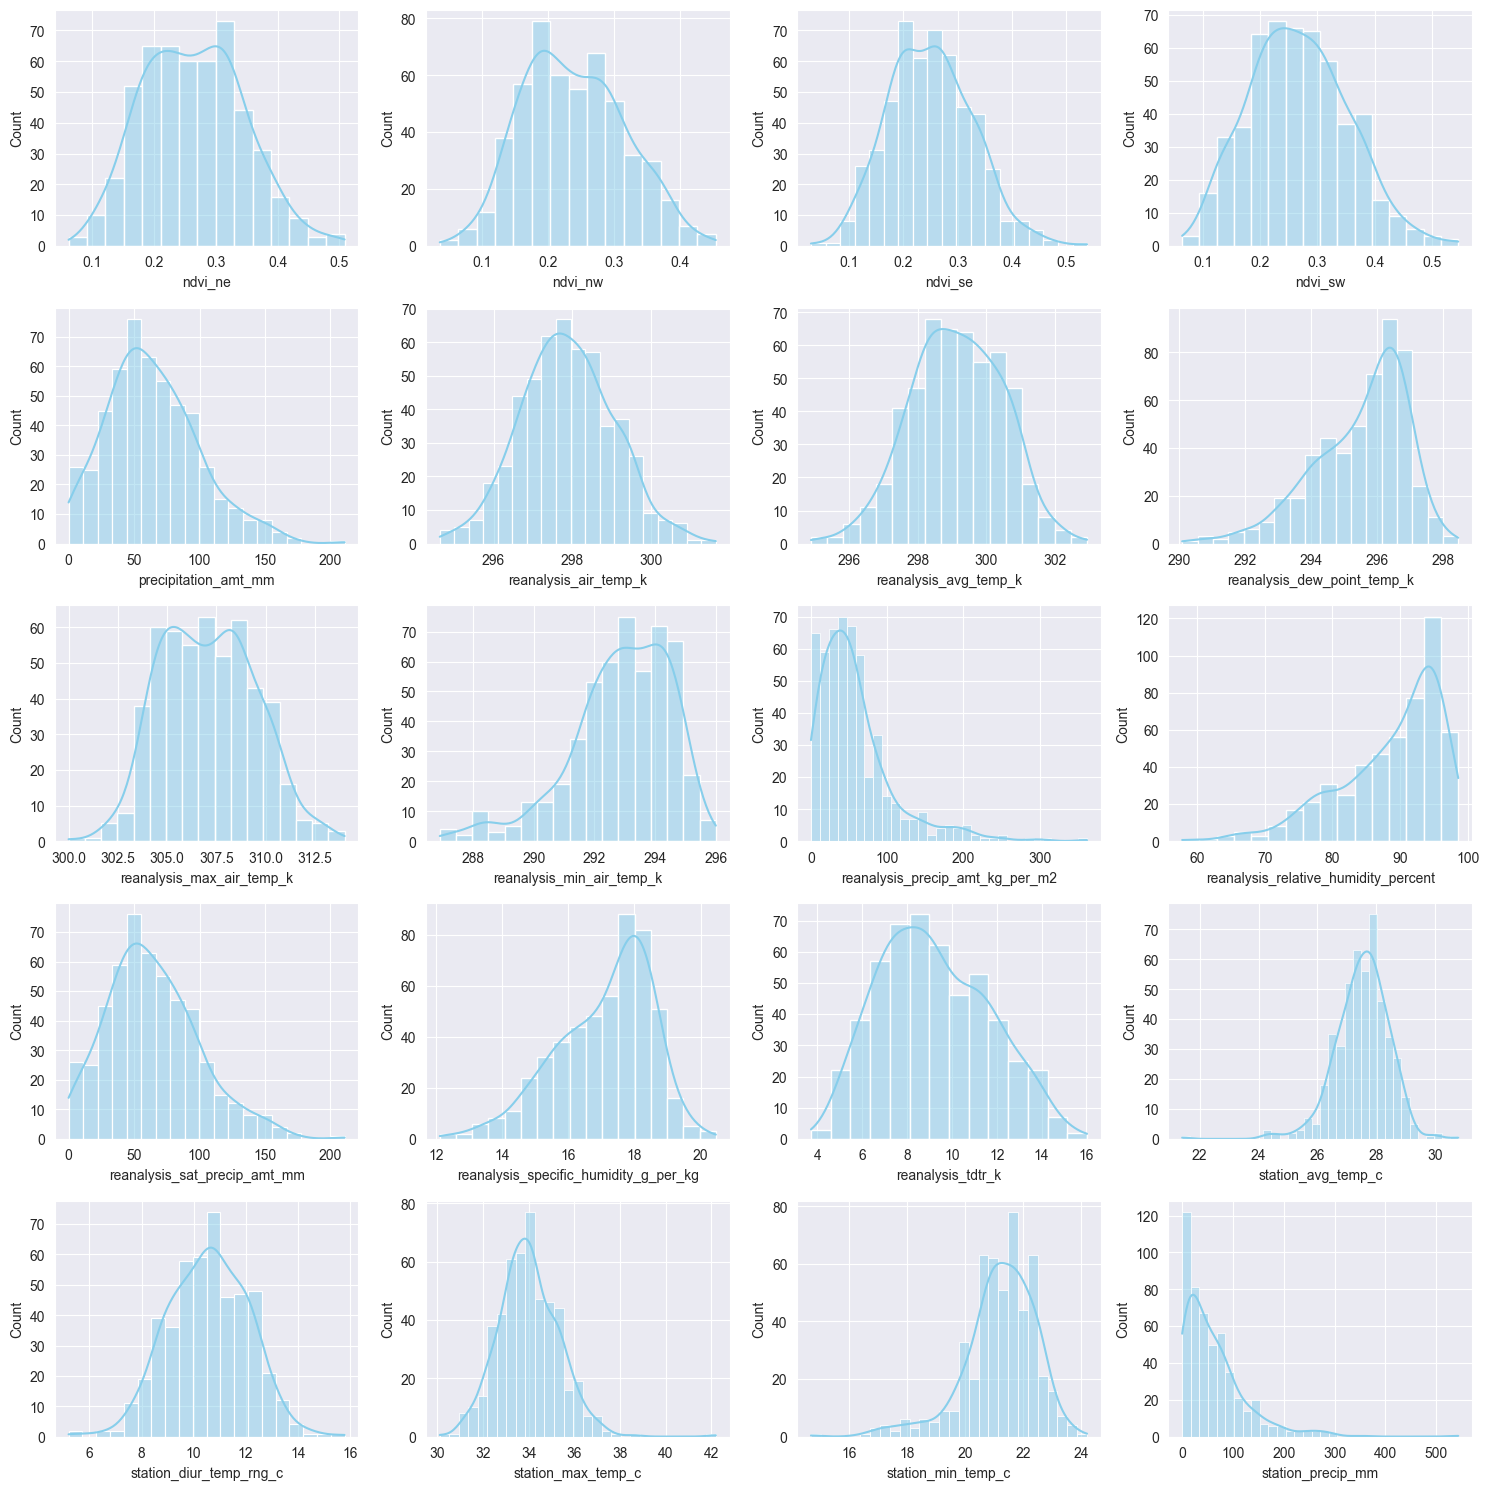

In [565]:
attribute_distribution_histogram(df_iq_ignored,5,4)

### Ausreißer

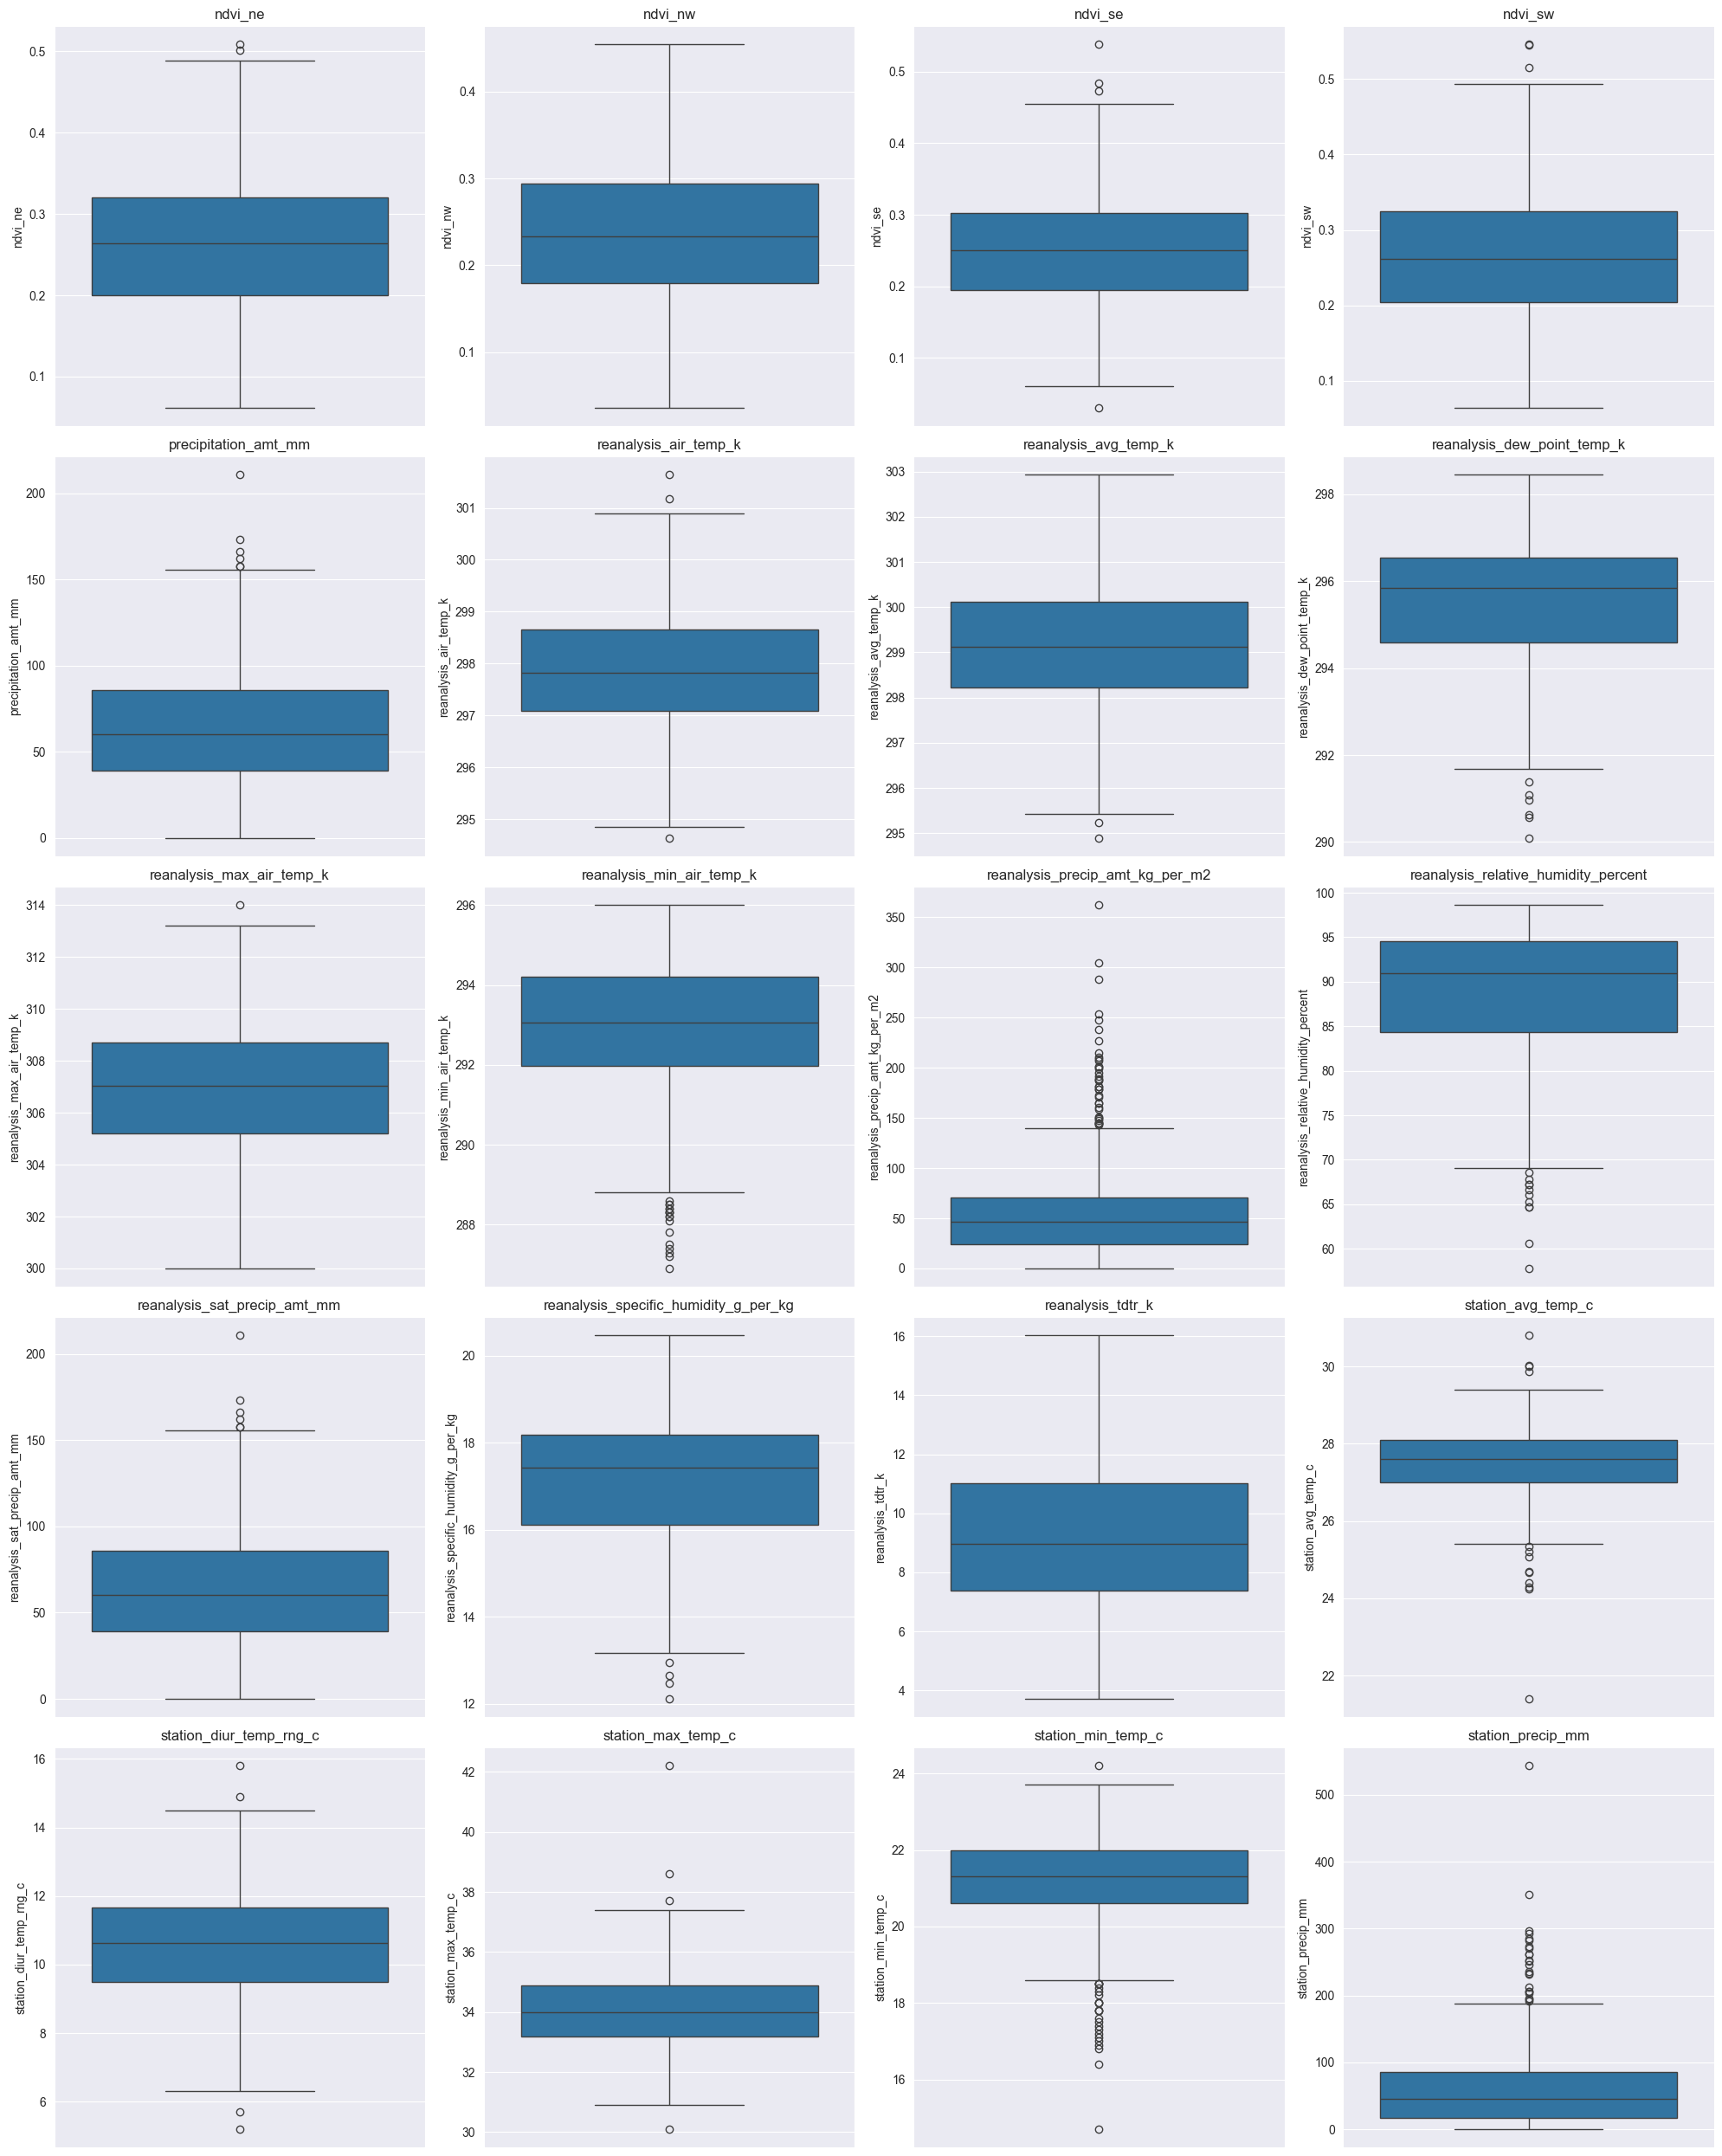

In [566]:
outlier_boxplot(df_iq_ignored)

### Korrelation

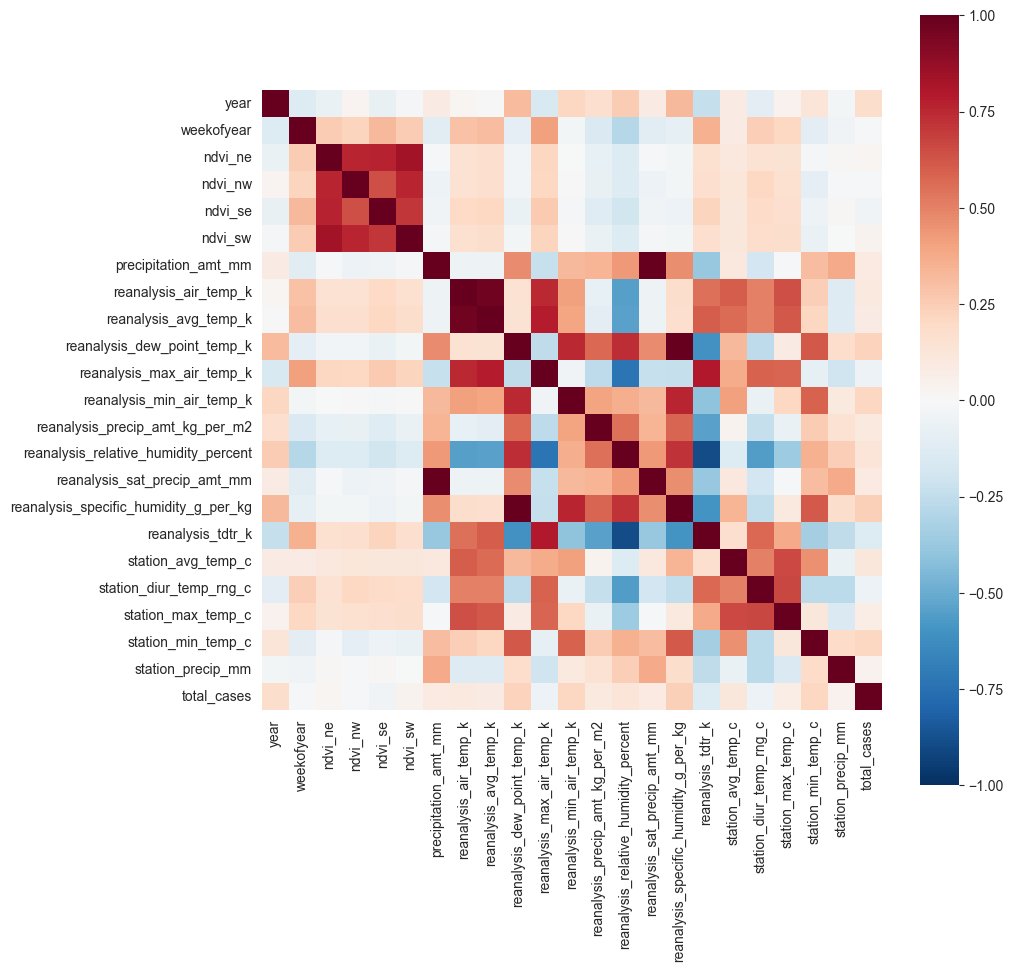

In [567]:
correlation_matrix(df_iq_train,df_iq_labels,df_iq_train.columns.tolist(),False)

Im Gesamtbild unterscheidet sich die Korrelation des Iquitos-Datensatzes an manchen Stellen sehr von San Juan. An manchen Punkten ist die Korrelation gleich geblieben. In der weiteren Analyse wird aufgedeckt, welche Attribute miteinander und mit der Zielvariable stark oder schwach korrelieren.  

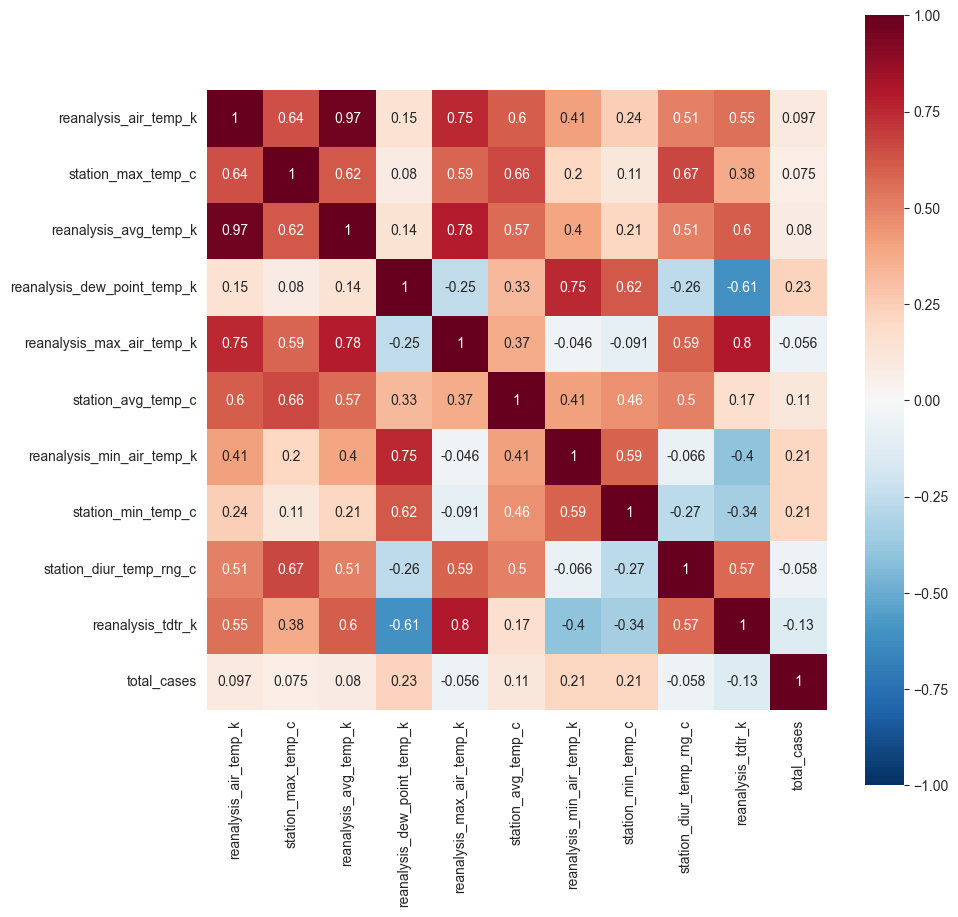

In [568]:
# Temperaturdaten
correlation_matrix(df_iq_train,df_iq_labels, ['reanalysis_air_temp_k',
                           'station_max_temp_c',
                           'reanalysis_avg_temp_k',
                           'reanalysis_dew_point_temp_k',
                           'reanalysis_max_air_temp_k',
                           'station_avg_temp_c',
                           'reanalysis_min_air_temp_k',
                           'station_min_temp_c',
                           'station_diur_temp_rng_c',
                           'reanalysis_tdtr_k',
                           ],True)

Die Attribute der Temperatur korrelieren nicht mehr so stark untereinander und auch nicht mit der Zielvariable. Dafür korrelieren andere Attribute nun mehr mit der Zielvariable (z.B. 'reanalysis_min_air_temp_k'). Für die Auswahl der für das Model benötigten Variablen werden die am stärksten korrelierenden Variablen genommen ('reanalysis_dew_point_temp_k','reanalysis_min_air_temp_k','station_min_temp_c'). Wichtig ist auch Attribute zu beachten, die negativ mit der Zielvariable korrelieren, da sie eine negativ-lineare Beziehung aufweisen ('reanalysis_tdtr_k'). 

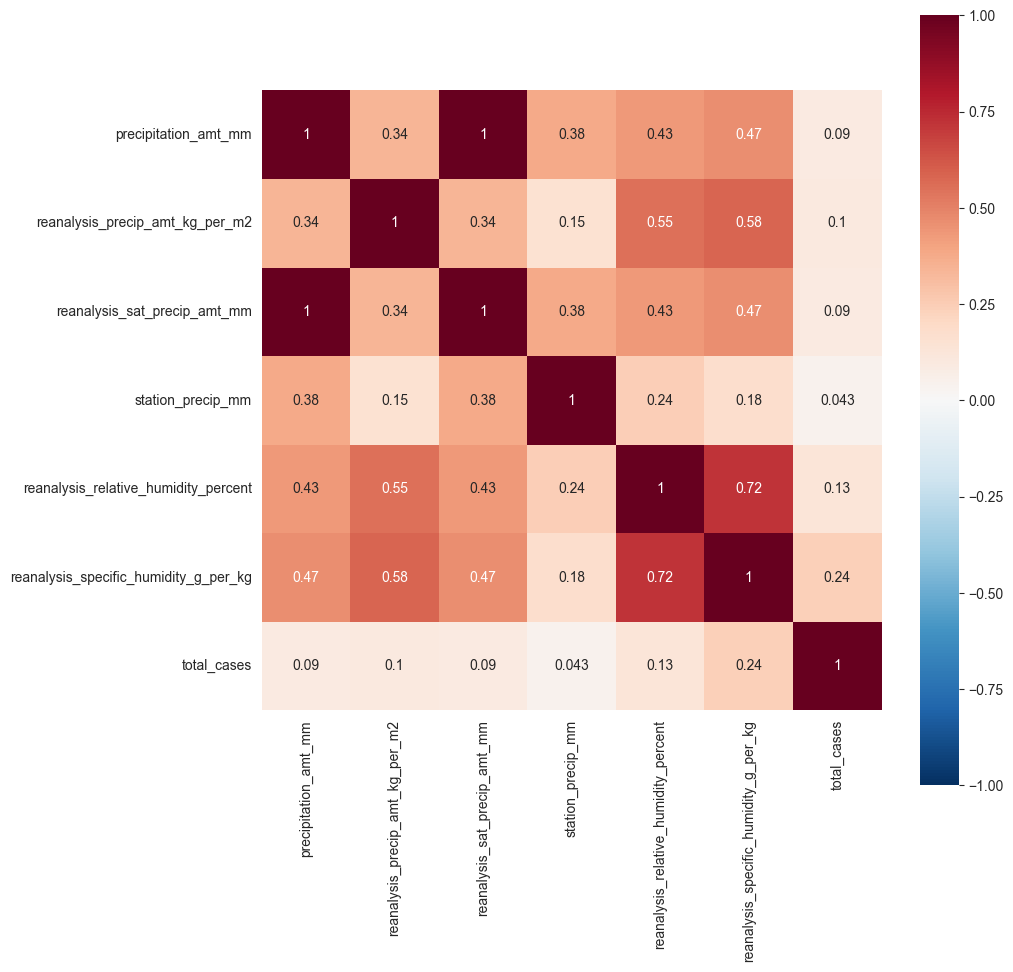

In [569]:
# Niederschlagsdaten
correlation_matrix(df_iq_train,df_iq_labels,['precipitation_amt_mm',
                             'reanalysis_precip_amt_kg_per_m2',
                             'reanalysis_sat_precip_amt_mm',
                             'station_precip_mm',
                             'reanalysis_relative_humidity_percent',
                             'reanalysis_specific_humidity_g_per_kg'],True)

Auch hier werden die meist-korrelierenden Attribute für das weitere verfahren ausgewählt ('reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent'). Auch hier ist die korrelation zwischen 'precipitation_amt_mm' und 'reanalysis_sat_precip_amt_mm' identisch.

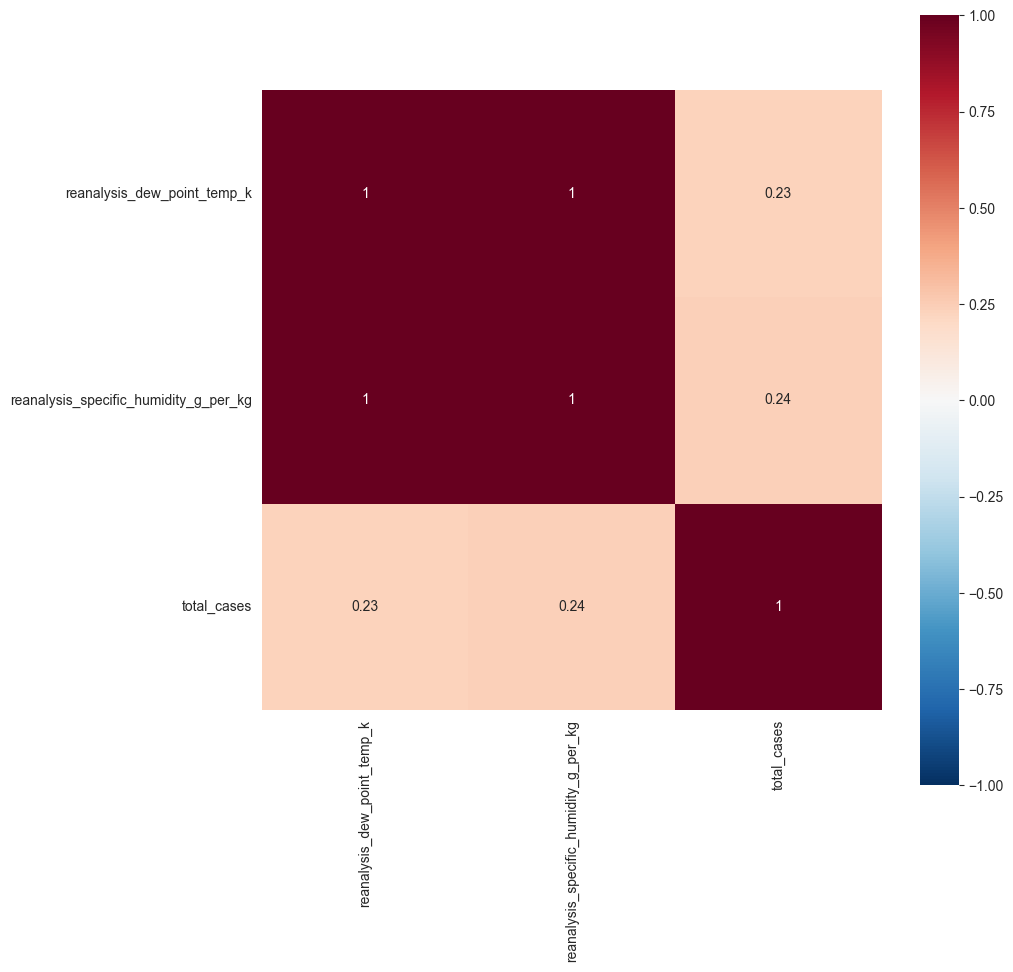

In [570]:
correlation_matrix(df_iq_train,df_iq_labels,['reanalysis_dew_point_temp_k',
                             'reanalysis_specific_humidity_g_per_kg'],True)

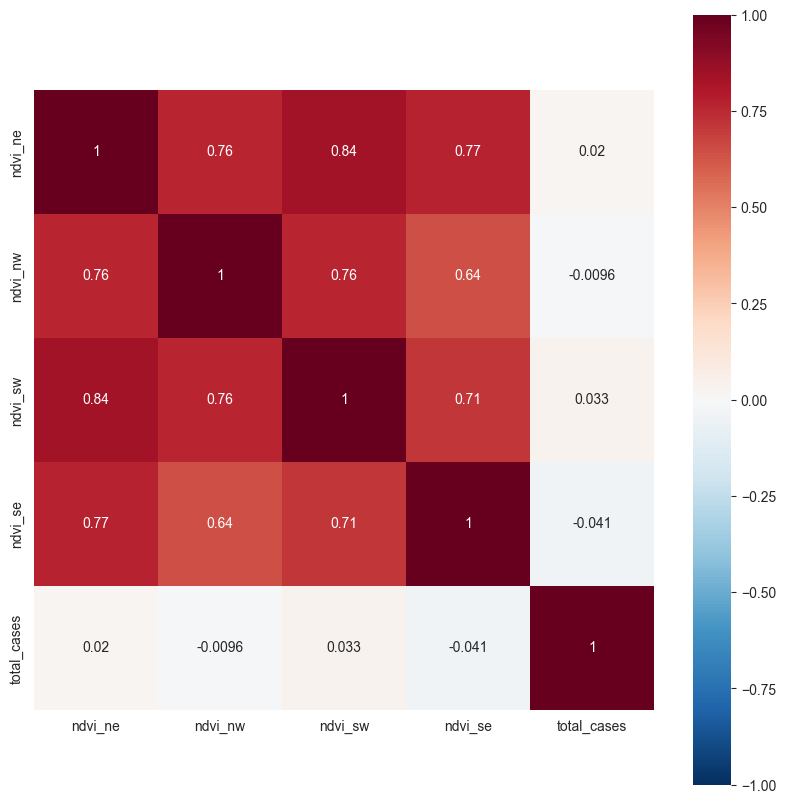

In [571]:
correlation_matrix(df_iq_train,df_iq_labels,['ndvi_ne','ndvi_nw','ndvi_sw','ndvi_se'],True)

C:\Users\rener\AppData\Local\Temp\ipykernel_23448\3328193609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iq_train['total_cases']=df_iq_labels['total_cases']
C:\Users\rener\AppData\Local\Temp\ipykernel_23448\3328193609.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  iq_correlations = df_iq_train.corr()


<AxesSubplot: >

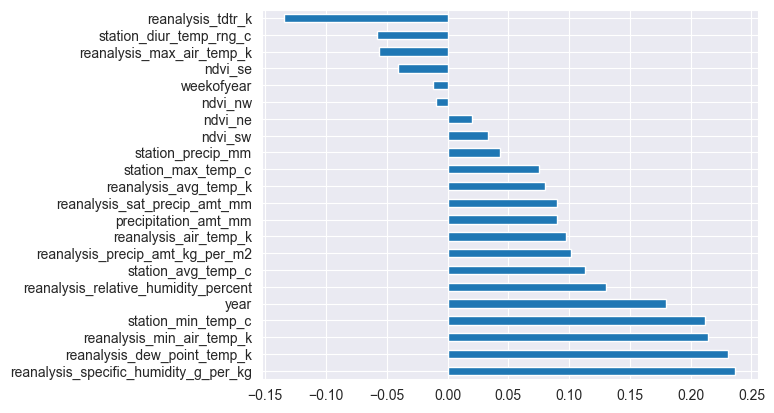

In [572]:
df_iq_train['total_cases']=df_iq_labels['total_cases']
iq_correlations = df_iq_train.corr()
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

### Attribute
Ein DataFrame mit allen Attributen

In [573]:
df_iq_model_features = df_iq_train[['reanalysis_dew_point_temp_k','reanalysis_min_air_temp_k','station_min_temp_c','reanalysis_tdtr_k','reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent','reanalysis_precip_amt_kg_per_m2','station_avg_temp_c']].copy()
df_iq_model_features['total_cases'] = df_iq_labels['total_cases'].copy()

# Behandlung von fehlenden Daten
Hier wurde wieder die Verbesserung von "conditg" verwendet. [Link](https://github.com/conditg/deng-ai/blob/master/Iquitos.ipynb)

In [574]:
#Increment all week values by one for all problem years
df_iq_train.loc[:,'weekofyear_fixed'] = np.where(df_iq_train.year==2005,df_iq_train.weekofyear+1, df_iq_train.weekofyear)
df_iq_train.loc[:,'weekofyear_fixed'] = np.where(df_iq_train.year==2006,df_iq_train.weekofyear_fixed+1, df_iq_train.weekofyear_fixed)
df_iq_train.loc[:,'weekofyear_fixed'] = np.where(df_iq_train.year==2010,df_iq_train.weekofyear_fixed+1, df_iq_train.weekofyear_fixed)

#Reduce any week values over 52 down to 1    
df_iq_train.loc[:,'weekofyear_fixed'] = np.where(df_iq_train.weekofyear_fixed>52,1, df_iq_train.weekofyear_fixed)


#Increment all week values by one for all problem years
df_iq_labels.loc[:,'weekofyear_fixed'] = np.where(df_iq_labels.year==2012,df_iq_labels.weekofyear+1, df_iq_labels.weekofyear)
df_iq_labels.loc[:,'weekofyear_fixed'] = np.where(df_iq_labels.year==2011,df_iq_labels.weekofyear_fixed+1, df_iq_labels.weekofyear_fixed)

#Reduce any week values over 52 down to 1    
df_iq_labels.loc[:,'weekofyear_fixed'] = np.where(df_iq_labels.weekofyear_fixed>52,1, df_iq_labels.weekofyear_fixed)


C:\Users\rener\AppData\Local\Temp\ipykernel_23448\273905259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iq_train.loc[:,'weekofyear_fixed'] = np.where(df_iq_train.year==2005,df_iq_train.weekofyear+1, df_iq_train.weekofyear)
C:\Users\rener\AppData\Local\Temp\ipykernel_23448\273905259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iq_train.loc[:,'weekofyear_fixed'] = np.where(df_iq_train.year==2006,df_iq_train.weekofyear_fixed+1, df_iq_train.weekofyear_fixed)
C:\Users\rener\AppData\Local\Tem

In [575]:
df_iq_model_features['weekofyear_fixed'] = df_iq_train['weekofyear_fixed']
df_iq_model_features['weekofyear_fixed'] = df_iq_labels['weekofyear_fixed']

In [576]:
df_iq_model_features = df_iq_model_features.interpolate(method='linear', limit_direction='both', limit=26)

# Aufbau des Models

In [577]:
x = df_iq_model_features.drop(['total_cases'], axis=1)
y = df_iq_model_features['total_cases']
iq_x_train, iq_x_test, iq_y_train, iq_y_test = train_test_split(x, y, test_size=0.3, random_state=42,shuffle=False)

### Lineare Regression

In [578]:
linear_reg_iq = LinearRegression()
linear_reg_iq.fit(iq_x_train,iq_y_train)
y_pred_linear_reg = linear_reg_iq.predict(iq_x_test)
print(cross_val_score(linear_reg_iq,sj_x_train,sj_y_train,scoring='neg_mean_absolute_error', cv=4))
print(mean_absolute_error(iq_y_test,y_pred_linear_reg,multioutput='uniform_average'))

[-25.63400191 -30.75348918 -26.36999005 -21.05415642]
7.625734724969474


In [579]:
linear_reg_iq.score(iq_x_test,iq_y_test)

-0.05042026624925122

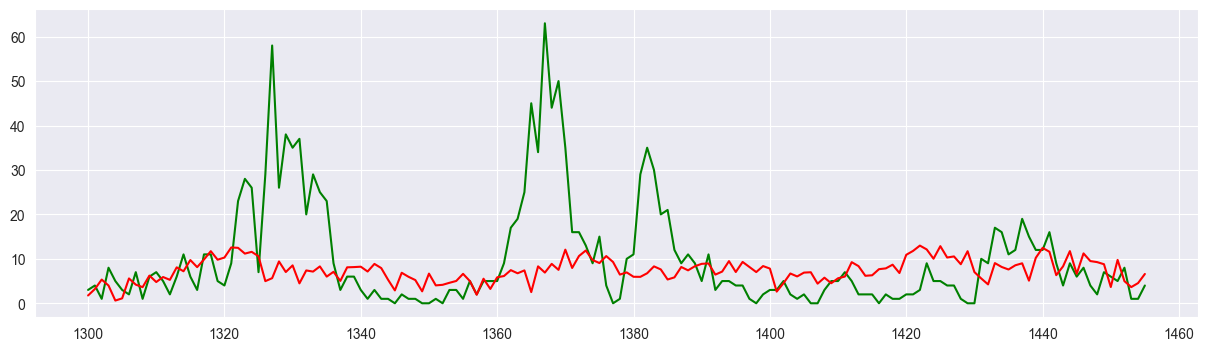

In [580]:
examine(y_pred_linear_reg, iq_y_test)

# Feature Engineering

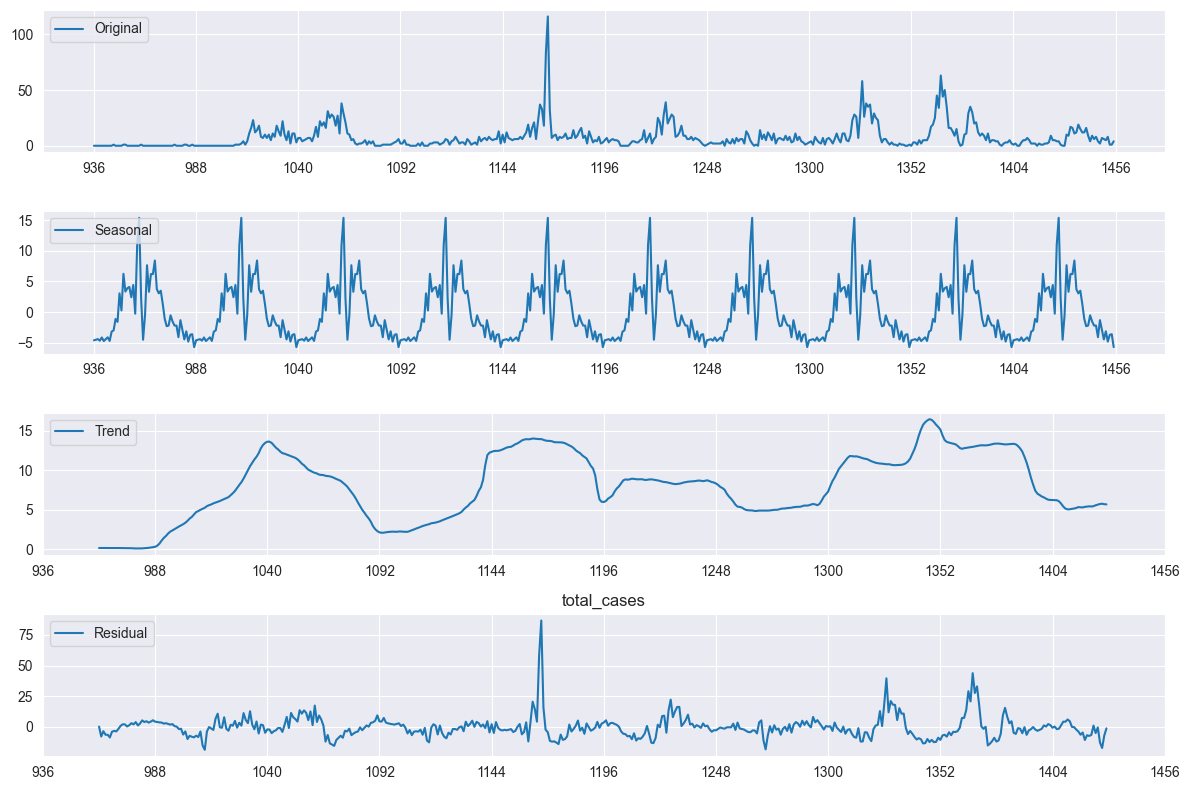

In [581]:
ticks = [936, 988, 1040, 1092, 1144, 1196, 1248, 1300, 1352, 1404, 1456]
time_series_decomp(df_iq_model_features,'total_cases',ticks)

In [582]:
df_iq_lineplot = df_iq_train[['weekofyear_fixed', 'year']].copy()
df_iq_lineplot['total_cases'] = df_iq_labels['total_cases'].copy()

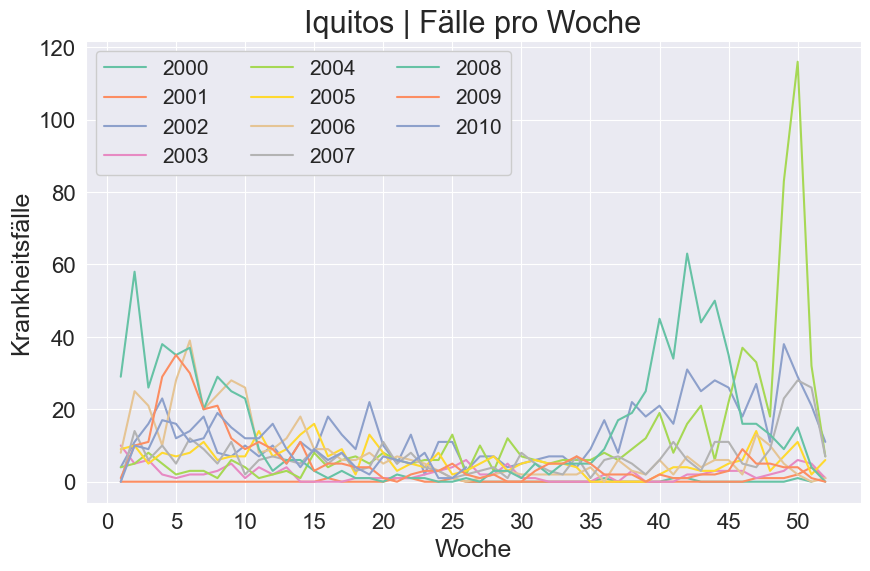

In [583]:
plt.figure(figsize=[10, 6])
sns.lineplot(x='weekofyear_fixed', y='total_cases', hue='year',
             data=df_iq_lineplot, palette='Set2', legend='full')
plt.legend(loc=2, framealpha=1, ncol=3, prop={'size': 15})
plt.ylabel('Krankheitsfälle', size=18)
plt.xlabel('Woche', size=18)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], size=16)
plt.yticks(size=16)
plt.title('Iquitos | Fälle pro Woche', size=22)
plt.show()

Hier kann man 4 Phasen sehen:
1. Von Woche 1-12
2. Von Woche 13-24
3. Von Woche 25-36
4. Von Woche 36-52

In [584]:
for index, row in df_iq_train.iterrows():
    phase = 0
    if 0 <= row['weekofyear_fixed'] <= 12:
        phase = 1
    elif 13 <= row['weekofyear_fixed'] <= 24:
        phase = 2
    elif 25 <= row['weekofyear_fixed'] <= 36:
        phase = 3
    elif 37 <= row['weekofyear_fixed'] <= 52:
        phase = 4

    df_iq_model_features.loc[index, 'phase1'] = 1 if phase == 1 else 0
    df_iq_model_features.loc[index, 'phase2'] = 1 if phase == 2 else 0
    df_iq_model_features.loc[index, 'phase3'] = 1 if phase == 3 else 0
    df_iq_model_features.loc[index, 'phase4'] = 1 if phase == 4 else 0

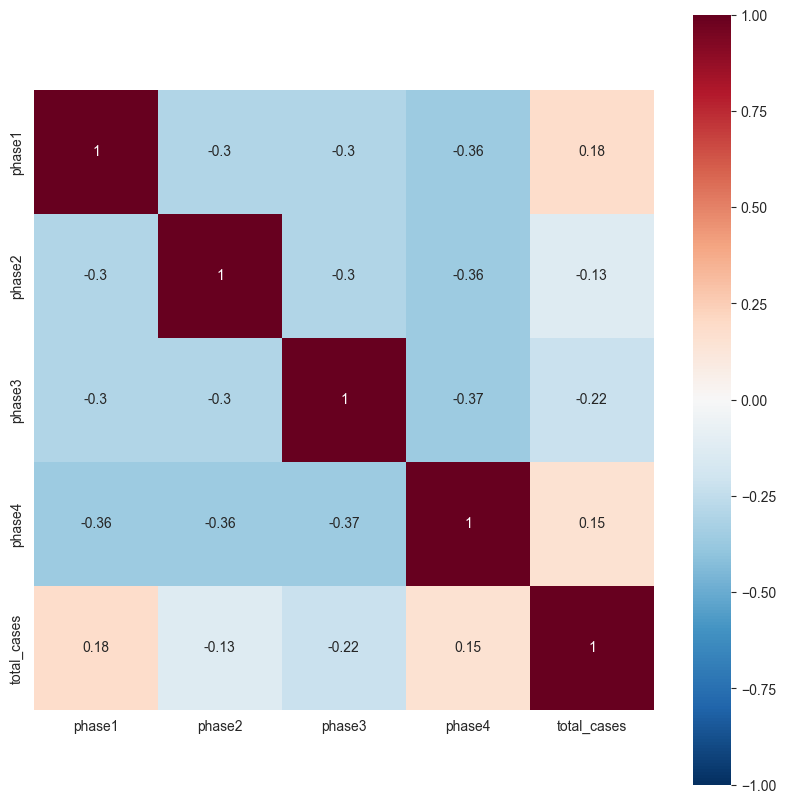

In [585]:
correlation_matrix(df_iq_model_features,df_iq_model_features,['phase1','phase2','phase3','phase4'],True)

Alle vier Phasen beeinflussen die Zielvariable positiv oder negativ, daher werden alle in die Vorhersage miteinbezogen. 

In [586]:
x = df_iq_model_features.drop(['total_cases'], axis=1)
y = df_iq_model_features['total_cases']
iq_x_train, iq_x_test, iq_y_train, iq_y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=False)

In [587]:
iq_x_test.columns

Index(['reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'reanalysis_tdtr_k',
       'reanalysis_specific_humidity_g_per_kg',
       'reanalysis_relative_humidity_percent',
       'reanalysis_precip_amt_kg_per_m2', 'station_avg_temp_c',
       'weekofyear_fixed', 'phase1', 'phase2', 'phase3', 'phase4'],
      dtype='object')

In [588]:
linear_reg_iq = LinearRegression()
linear_reg_iq.fit(iq_x_train, iq_y_train)
y_pred_linear_reg = linear_reg_iq.predict(iq_x_test)
print(cross_val_score(linear_reg_iq, iq_x_train, iq_y_train, scoring='neg_mean_absolute_error', cv=4))
print(mean_absolute_error(iq_y_test, y_pred_linear_reg, multioutput='uniform_average'))

[-6.90275309 -6.62424358 -7.18010539 -6.25149554]
7.182343294728333


In [589]:
linear_reg_iq.score(iq_x_test, iq_y_test)

0.021379280150252034

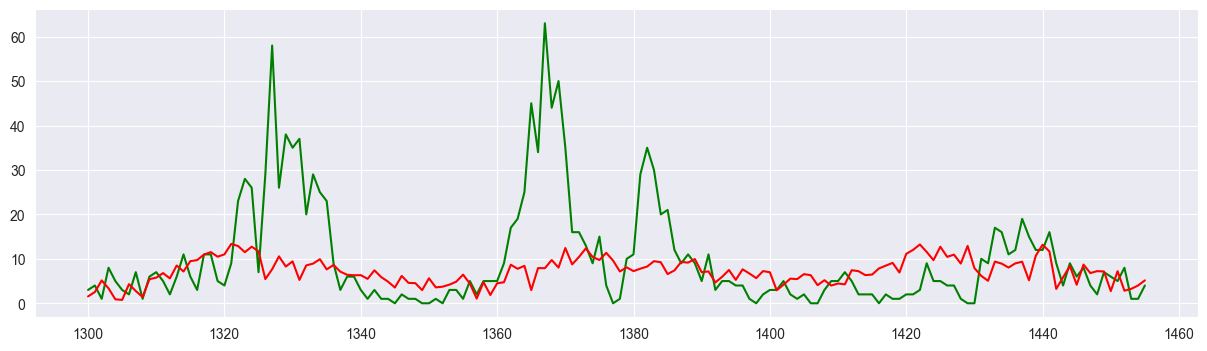

In [590]:
examine(y_pred_linear_reg, iq_y_test)

In [591]:
x = df_iq_model_features.drop(['total_cases'], axis=1)
y = df_iq_model_features['total_cases']
iq_x_train_rndm, iq_x_test_rndm, iq_y_train_rndm, iq_y_test_rndm = train_test_split(x, y, test_size=0.3,
                                                                                    random_state=42)

[-7.57106525 -6.10628274 -6.88230402 -5.30691691]
6.5057537984885005
0.10864332974819768


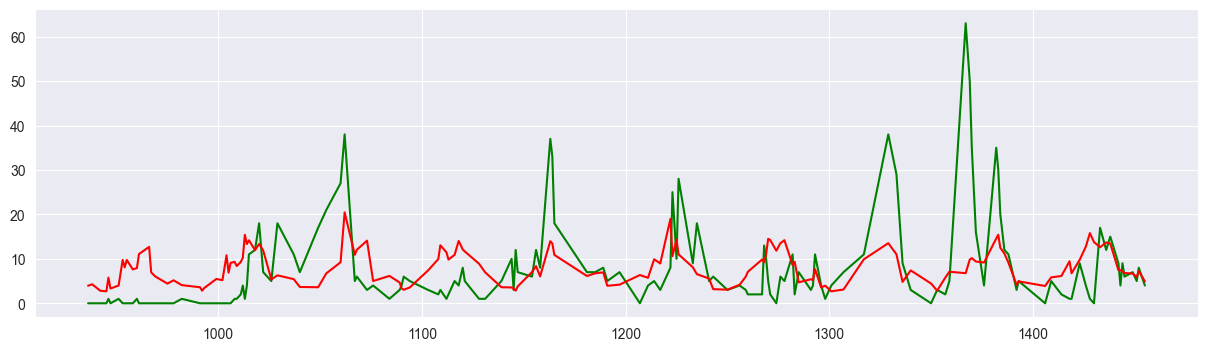

In [592]:
rndm_forest_regr_iq = RandomForestRegressor(max_depth=4, random_state=0)
rndm_forest_regr_iq.fit(iq_x_train_rndm, iq_y_train_rndm)
y_pred_rndm = rndm_forest_regr_iq.predict(iq_x_test_rndm)
print(cross_val_score(rndm_forest_regr_iq, iq_x_train_rndm, iq_y_train_rndm, scoring='neg_mean_absolute_error', cv=4))
print(mean_absolute_error(iq_y_test_rndm, y_pred_rndm, multioutput='uniform_average'))
print(rndm_forest_regr_iq.score(iq_x_test_rndm, iq_y_test_rndm))
examine(y_pred_rndm, iq_y_test_rndm)

## Feature Importance
Die Feature Importance wurde schon durch Verwendung des Korrelationsindexes durchgeführt. Da die ausgewählten Variablen den Datensatz nicht gut beschreiben wird nun eine Feature Importance über alle Variablen mithilfe von Random Forest durchgeführt. Das Ziel ist es, die für die Vorhersage wichtigen Features zu ermitteln.

In [593]:
df_all_features_iq = df_iq_train.copy()
df_all_features_iq.drop(columns=["weekofyear_fixed", "total_cases", "year", "city", "week_start_date"],
                     inplace=True)
df_all_features_iq = df_all_features_iq.interpolate(method='linear', limit_direction='both', limit=26)
df_all_features_iq['phase2'] = df_iq_model_features['phase2'].copy()
df_all_features_iq['phase3'] = df_iq_model_features['phase3'].copy()
df_all_features_iq['phase4'] = df_iq_model_features['phase4'].copy()
df_all_features_iq['phase1'] = 0
df_all_features_iq.loc[(df_all_features_iq['phase2'] == 0) & (df_all_features_iq['phase3'] == 0) & (df_all_features_iq['phase4'] == 0), 'phase1'] = 1

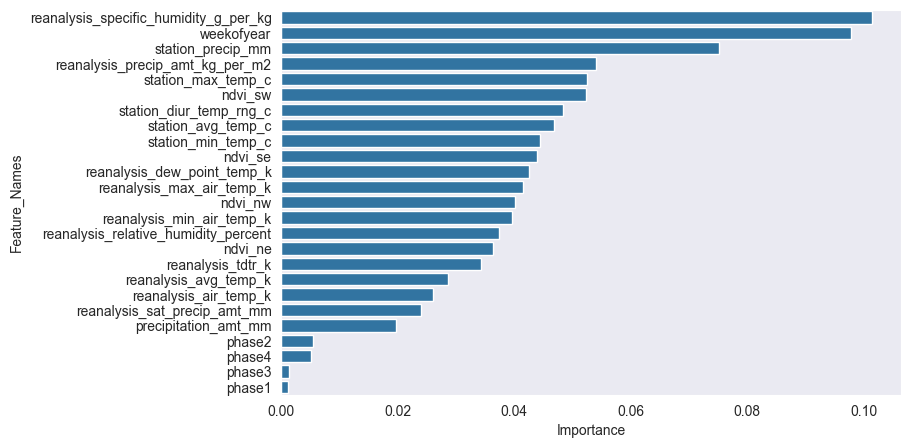

In [594]:
X = df_all_features_iq
y = df_iq_labels['total_cases']
names = df_all_features_iq.columns.values.tolist()

rf_classifier = RandomForestRegressor()
rf_classifier.fit(X, y)
importance = {
    'Feature_Names': names,
    'Importance': rf_classifier.feature_importances_
}
feature_importance = pd.DataFrame(importance)
plt.figure(figsize=(8, 5))
plt.grid()
sns.barplot(x="Importance", y="Feature_Names", data=feature_importance.sort_values(by="Importance", ascending=False))
selected_features_iq = feature_importance[feature_importance['Importance'] >= 0.045]
selected_feature_names_iq = selected_features_iq['Feature_Names'].tolist()

[-6.83587912 -5.37467033 -6.86115385 -4.82851648]
5.96823717948718
0.06285743066910332


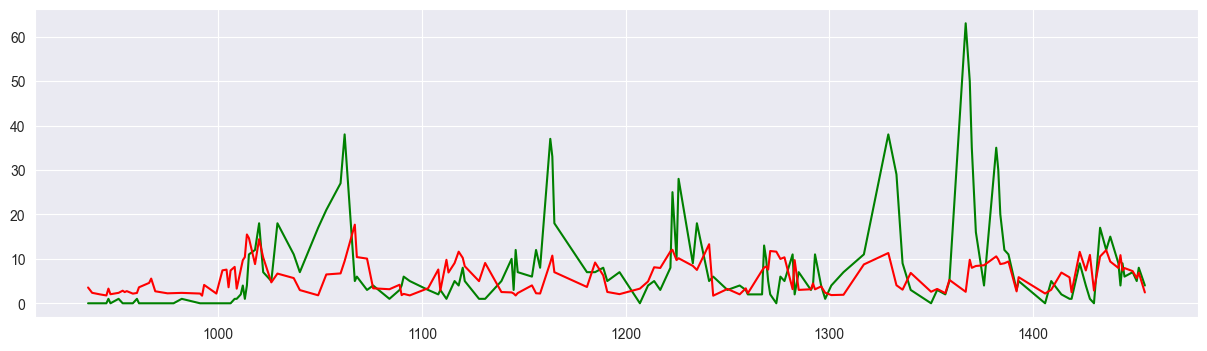

In [595]:
x = df_all_features_iq[selected_feature_names_iq]
y = df_iq_model_features['total_cases']
iq_x_train_rndm, iq_x_test_rndm, iq_y_train_rndm, iq_y_test_rndm = train_test_split(x, y, test_size=0.3,
                                                                                    random_state=42)
rndm_forest_regr_iq = RandomForestRegressor(criterion="absolute_error",max_depth=4)
rndm_forest_regr_iq.fit(iq_x_train_rndm, iq_y_train_rndm)
y_pred_rndm = rndm_forest_regr_iq.predict(iq_x_test_rndm)
print(cross_val_score(rndm_forest_regr_iq, iq_x_train_rndm, iq_y_train_rndm, scoring='neg_mean_absolute_error', cv=4))
print(mean_absolute_error(iq_y_test_rndm, y_pred_rndm, multioutput='uniform_average'))
print(rndm_forest_regr_iq.score(iq_x_test_rndm, iq_y_test_rndm))
examine(y_pred_rndm, iq_y_test_rndm)

# Vorhersage der Testdaten
Nun werden die Testdaten aus der Datei aus DrivenData vorhergesagt

In [596]:
def preprocess_sj(df_train):
    # Choose Feature Columns
    df_feat = df_train[['station_max_temp_c','reanalysis_relative_humidity_percent','reanalysis_precip_amt_kg_per_m2']].copy()
    #Normalize Columns
    temp_cols = ['reanalysis_air_temp_k',
                           'reanalysis_avg_temp_k',
                           'reanalysis_max_air_temp_k',
                           'station_avg_temp_c',
                           'reanalysis_min_air_temp_k',
                           'station_min_temp_c',
                           'reanalysis_dew_point_temp_k']
    humid_cols = ['reanalysis_specific_humidity_g_per_kg']
    normalize_cols(df_train,df_feat,temp_cols,'temp_avg')
    normalize_cols(df_train,df_feat,humid_cols,'norm_humid_amount')
    scaler = MinMaxScaler()
    norm_atts = ['station_max_temp_c', 'reanalysis_relative_humidity_percent', 'reanalysis_precip_amt_kg_per_m2']
    df_feat[norm_atts] = scaler.fit_transform(df_feat[norm_atts])
    # Fix Week-Problem
    df_train.loc[:,'weekofyear_fixed'] = np.where(df_train.year==2010,
                                              df_train.weekofyear+1, df_train.weekofyear) 
    for year in [2011,2012]:
        df_train.loc[:,'weekofyear_fixed'] = np.where(df_train.year==year,
                                                      df_train.weekofyear_fixed+1, df_train.weekofyear_fixed)
    df_train.loc[:,'weekofyear'] = np.where(df_train.weekofyear_fixed>52,
                                            1, df_train.weekofyear_fixed)
    df_feat['weekofyear_fixed'] = df_train['weekofyear_fixed'].copy()
    # Interpolate Missing Data
    df_feat = df_feat.interpolate(method='pad')
    # Phase
    for index, row in df_train.iterrows():
        phase = 0
        if 0 <= row['weekofyear_fixed'] <= 11:
            phase = 1
        elif 12 <= row['weekofyear_fixed'] <= 22:
            phase = 2
        elif 23 <= row['weekofyear_fixed'] <= 52:
            phase = 3
        df_feat.loc[index, 'phase1'] = 1 if phase == 1 else 0
        df_feat.loc[index, 'phase2'] = 1 if phase == 2 else 0
        df_feat.loc[index, 'phase3'] = 1 if phase == 3 else 0
    df_feat.drop(columns=['phase1'],inplace=True)
    return df_feat

In [597]:
def preprocess_iq(df_train):
    # Choose Feature Columns
    df_feat = df_train[['reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'reanalysis_tdtr_k',
       'reanalysis_specific_humidity_g_per_kg',
       'reanalysis_relative_humidity_percent',
       'reanalysis_precip_amt_kg_per_m2', 'station_avg_temp_c']].copy()
    # Wochen müssen nicht angepasst werden, da im Testdatensatz Iquitos keine Woche 53 vorkommt
    df_feat['weekofyear_fixed'] = df_train['weekofyear'].astype(int).copy()
    # Interpolate Missing Data
    df_feat = df_feat.interpolate(method='pad')
    # Phase
    for index, row in df_train.iterrows():
        phase = 0
        if 0 <= row['weekofyear'] <= 12:
            phase = 1
        elif 13 <= row['weekofyear'] <= 24:
            phase = 2
        elif 25 <= row['weekofyear'] <= 36:
            phase = 3
        elif 37 <= row['weekofyear'] <= 52:
            phase = 4

        df_feat.loc[index, 'phase1'] = 1 if phase == 1 else 0
        df_feat.loc[index, 'phase2'] = 1 if phase == 2 else 0
        df_feat.loc[index, 'phase3'] = 1 if phase == 3 else 0
        df_feat.loc[index, 'phase4'] = 1 if phase == 4 else 0
    df_feat[['phase1', 'phase2', 'phase3', 'phase4']] = df_feat[['phase1', 'phase2', 'phase3', 'phase4']].astype(int)
    return df_feat

In [598]:
df_test = pd.read_csv("dataset/dengue_features_test.csv")

In [599]:
df_sj_test = df_test.loc[df_test['city']=='sj']
df_iq_test = df_test.loc[df_test['city']=='iq']

In [600]:
#df_sj_preprocess = preprocess_sj(df_sj_test)

In [601]:
df_iq_preprocess = preprocess_iq(df_iq_test)

In [602]:
for index, row in df_sj_test.iterrows():
        phase = 0
        if 23 <= row['weekofyear']:
            phase = 3
        df_sj_test.loc[index, 'phase3'] = 1 if phase == 3 else 0

C:\Users\rener\AppData\Local\Temp\ipykernel_23448\1947992890.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_test.loc[index, 'phase3'] = 1 if phase == 3 else 0


In [603]:
df_time = df_sj_test[["year","weekofyear"]].copy()

In [604]:
df_sj_test.drop(columns=["city","year","week_start_date"],inplace=True)

C:\Users\rener\AppData\Local\Temp\ipykernel_23448\3353528992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_test.drop(columns=["city","year","week_start_date"],inplace=True)


In [605]:
df_sj_test = df_sj_test.interpolate(method='linear', limit_direction='both', limit=26)

In [606]:
df_sj_preprocess = df_sj_test[selected_feature_names]

In [610]:
y_pred_rndm_forest_regr_sj = pd.DataFrame()

In [611]:
y_pred_rndm_forest_regr_iq = df_iq_test[['year', 'weekofyear']].copy()

In [612]:
y_pred_rndm_forest_regr_sj['total_cases'] = rndm_forest_regr_sj.predict(df_sj_preprocess)

In [613]:
y_pred_rndm_forest_regr_iq['total_cases'] = rndm_forest_regr_iq.predict(df_iq_preprocess)

In [614]:
y_pred_rndm_forest_regr_sj = pd.concat([df_time[['year', 'weekofyear']], y_pred_rndm_forest_regr_sj], axis=1)

In [615]:
y_pred_rndm_forest_regr_sj['city'] = 'sj'
y_pred_rndm_forest_regr_iq['city'] = 'iq'

df_both_predicted_rndm = pd.concat([y_pred_rndm_forest_regr_sj, y_pred_rndm_forest_regr_iq], ignore_index=True)
df_both_predicted_rndm = df_both_predicted_rndm[['city'] + [col for col in df_both_predicted_rndm.columns if col != 'city']]

In [616]:
df_both_predicted_rndm['total_cases'] = df_both_predicted_rndm['total_cases'].round()
df_both_predicted_rndm['total_cases'] = df_both_predicted_rndm['total_cases'].astype(int)

In [617]:
# Die Wochen der Jahre 2010-2012 von sj müssen um 1 subtrahiert werden
#for year in [2010,2011,2012]:
#    df_both_predicted_rndm.loc[(df_both_predicted_rndm['city'] == "sj") & (df_both_predicted_rndm['year'] == year), 'weekofyear'] -= 1

In [618]:
#df_both_predicted_rndm.loc[(df_both_predicted_rndm['weekofyear']==0) & (df_both_predicted_rndm['year'] == 2010), #'weekofyear'] = 53

#df_both_predicted_rndm.loc[(df_both_predicted_rndm['weekofyear']==0) & (df_both_predicted_rndm['year'] != 2010), #'weekofyear'] = 52

In [619]:
df_both_predicted_rndm

city  year  weekofyear  total_cases
0     sj  2008          18            8
1     sj  2008          19            7
2     sj  2008          20            8
3     sj  2008          21            8
4     sj  2008          22           12
..   ...   ...         ...          ...
411   iq  2013          22            3
412   iq  2013          23            3
413   iq  2013          24            2
414   iq  2013          25            2
415   iq  2013          26            2

[416 rows x 4 columns]

In [620]:
df_both_predicted_rndm.to_csv('result.csv', index=False)